# Advanced Linear Regression
## Surprise Housing Case Study

#### Problem Statement:

- A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price,

- Build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.


# Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [361]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [394]:
# importing all the libs here
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Reusable Functions


In [363]:
def print_vif(df):
  # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
  vif = pd.DataFrame()
  vif['Features'] = df.columns
  vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  print(vif)

In [364]:
def build_model_print_statistics(X_train,y_train):
  #Build a linear model
  X_train_lm = sm.add_constant(X_train)
  model = sm.OLS(y_train, X_train_lm).fit()
  print(model.params)
  print(model.summary())
  return model,X_train_lm

Loading Data

In [365]:
housing = pd.read_csv("train.csv")

In [366]:
# Check the head of the dataset
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Inspect the various aspects of the dataframe

In [367]:
housing.shape
# Inference - 1460 Rows, 81 Columns

(1460, 81)

In [368]:
housing.info()
# Inference - some columns with null values.
# Data prep needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Check for duplicates

In [369]:
# check for duplicate rows based on id
any_duplicates=housing.duplicated(['Id']).any()
print(any_duplicates)
# no duplicate records found

False


Remove Empty columns

In [370]:
# remove empty columns
housing = housing.dropna(axis = 1, how = 'all')
housing.info(verbose=True, show_counts=True)

# no columns dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Drop rows with NA

In [371]:
#drop all the rows with only nan values
housing = housing.dropna(axis = 0, how = 'all')
housing.info()
# no of rows remains 1460

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Drop columns that high percentage of Nan

In [372]:
#drop columns that have high percentage of nan
print(housing.shape)
# keep columns where null percentage is less than 60%
housing = housing.loc[:, housing.isnull().mean() < .6]
# four columns with high percentage of nulls dropped
print(housing.shape)

(1460, 81)
(1460, 77)


Drop rows with high percentage of Nan

In [373]:
# drop rows that have high percentage of nan
perc = 60.0 
# calculates minimun number of columns without null value to reach 60%
min_count =  int(((100-perc)/100)*housing.shape[1] + 1)
#atleast 31 columns should be non na
print(min_count)
housing = housing.dropna( axis=0, 
                    thresh=min_count)
housing.shape
# no rows to drop , remains 1460

31


(1460, 77)

Data Manipulation

In [374]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Print all columns with missing values

In [375]:
def print_cols_with_missing_values():
  cols_with_missing_values = housing.isnull().sum().sort_values(ascending=False)
  display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], 
                      columns=["Number of Missing Values"]))
  
print_cols_with_missing_values()

,Number of Missing Values
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81
GarageQual,81
GarageCond,81
BsmtExposure,38
BsmtFinType2,38
BsmtQual,37


In [376]:
# data cleaning
# check every column which has nulls
# fix nulls
# derive columns from timestamps
# impute data where required

In [377]:
# columns GarageType has nulls -> impute
cat_columns=['FireplaceQu','GarageType','GarageCond','GarageFinish','GarageQual','BsmtFinType1','BsmtFinType2','BsmtExposure','BsmtCond','BsmtQual','MasVnrType']
# FireplaceQU: data description of the variables states that NA represents "no fireplace"
# GarageType: data description of the variables states that NA represents "no garage"
# GarageCond: data description of the variables states that NA represents "no garage"
# GarageFinish: data description of the variables states that NA represents "no garage"
# GarageQual: data description of the variables states that NA represents "no garage"
# BsmtFinType1 : : data description of the variables states that NA represents "no basement"
# BsmtFinType2 : : data description of the variables states that NA represents "no basement"
# BsmtExposure : : data description of the variables states that NA represents "no basement"
# BsmtCond : : data description of the variables states that NA represents "no basement"
# BsmtQual : : data description of the variables states that NA represents "no basement"
# MasVnrType: data description of the variables states that NA represents "no veneer"
for col in cat_columns:
  print(col)
  print('Before Cleaning')
  print(housing[col].isnull().sum())
  print(housing[col].unique())
  housing[col].fillna('None',inplace=True)
  print('After Cleaning')
  print(housing[col].unique())
  print(housing[col].isnull().sum())

FireplaceQu
Before Cleaning
690
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
After Cleaning
['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
0
GarageType
Before Cleaning
81
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
After Cleaning
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
0
GarageCond
Before Cleaning
81
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
After Cleaning
['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
0
GarageFinish
Before Cleaning
81
['RFn' 'Unf' 'Fin' nan]
After Cleaning
['RFn' 'Unf' 'Fin' 'None']
0
GarageQual
Before Cleaning
81
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
After Cleaning
['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
0
BsmtFinType1
Before Cleaning
37
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
After Cleaning
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
0
BsmtFinType2
Before Cleaning
38
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
After Cleaning
['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
0
BsmtExposure
Before Cleaning
38
['No' 'Gd' 'Mn' 'Av' nan]
After Cleaning
['No' 'Gd' 'Mn' 'Av' 'None']
0
BsmtCond
B

In [378]:
# GarageYrBlt -> missing values mean no garage, so impute with 0
# MasVnrArea -> missing values mean no veneer, so impute with 0
num_columns = ['GarageYrBlt','MasVnrArea']
for col in num_columns:
  print(col)
  print('Before Cleaning')
  housing[col].fillna(0,inplace=True)
  print('After Cleaning')
  print(housing[col].isnull().sum())

GarageYrBlt
Before Cleaning
After Cleaning
0
MasVnrArea
Before Cleaning
After Cleaning
0


In [379]:
#Impute electrical
print(housing['Electrical'].unique())
housing['Electrical'].describe()
# SBrkr is most frequently used
# replace one null with SBrkr
housing['Electrical'].fillna('SBrkr',inplace=True)
print(housing['Electrical'].unique())

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']


In [380]:
print_cols_with_missing_values()
# not sure how to impute LotFrontage
print('Before Cleaning')
print(housing['LotFrontage'].unique())
print(housing['LotFrontage'].isnull().sum())
# impute with what? - no clue - read more
# with median for now
housing['LotFrontage'].fillna(housing['LotFrontage'].median(),inplace=True)
print('After Cleaning')
print(housing['LotFrontage'].isnull().sum())

,Number of Missing Values
LotFrontage,259


Before Cleaning
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
259
After Cleaning
0


In [381]:
housing.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Step 2: Visualising the Data
Let's now spend some time doing what is arguably the most important step - understanding the data.

If there is some obvious multicollinearity going on, this is the first place to catch it
Here's where you'll also identify if some predictors directly have a strong association with the outcome variable
We'll visualise our data using matplotlib and seaborn.

### Visualize numerical columns


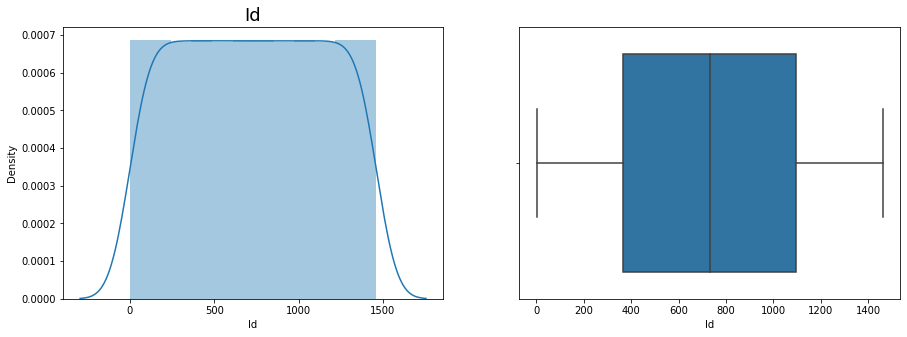

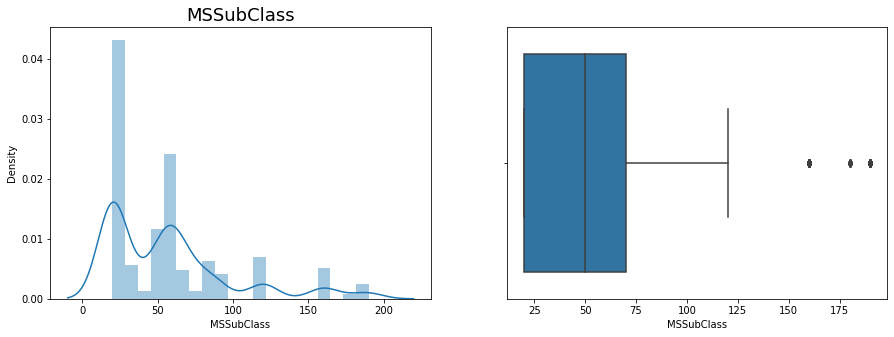

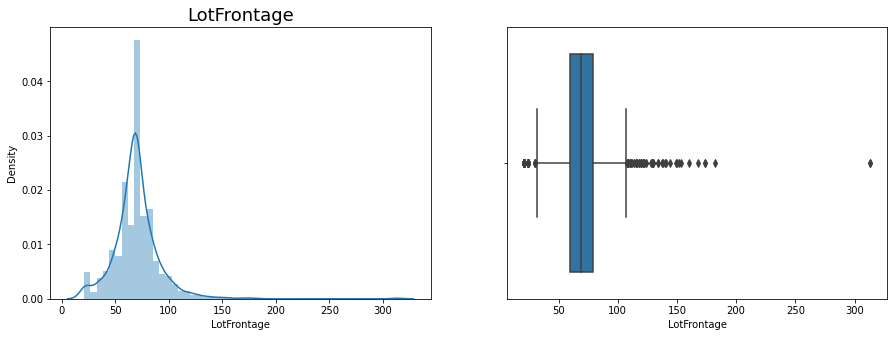

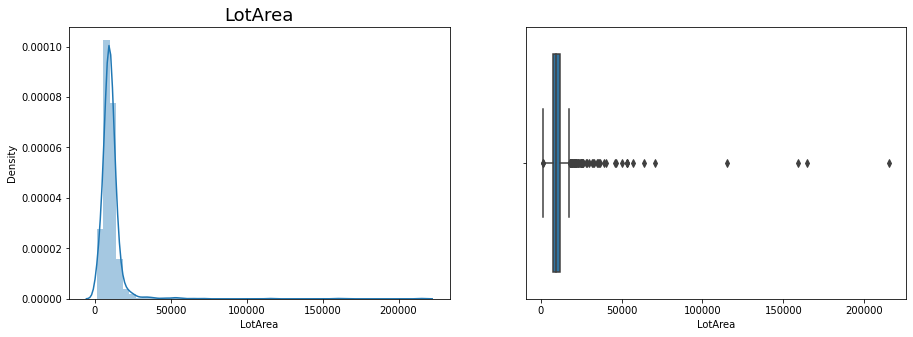

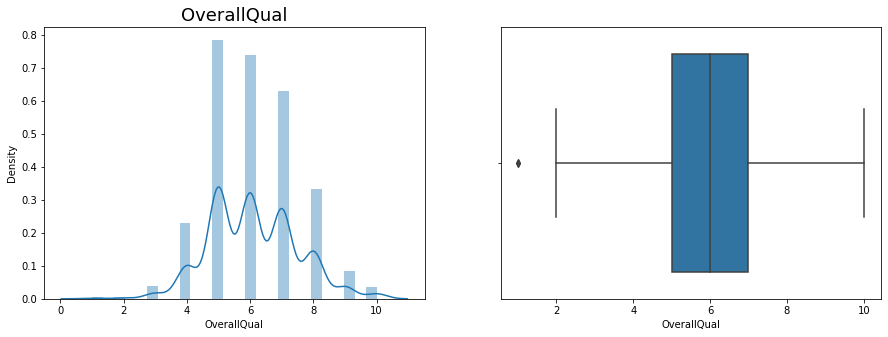

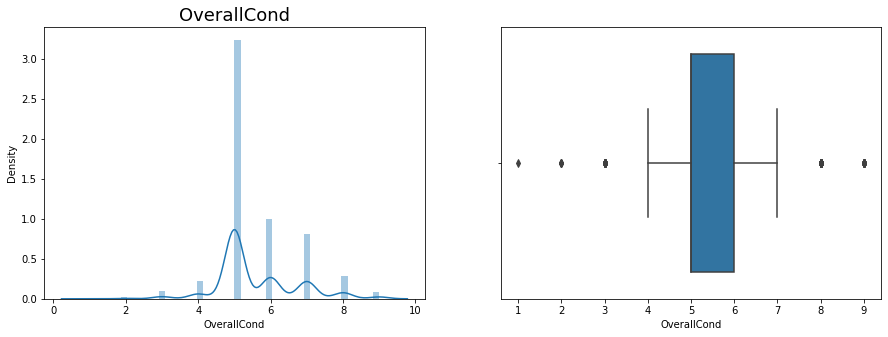

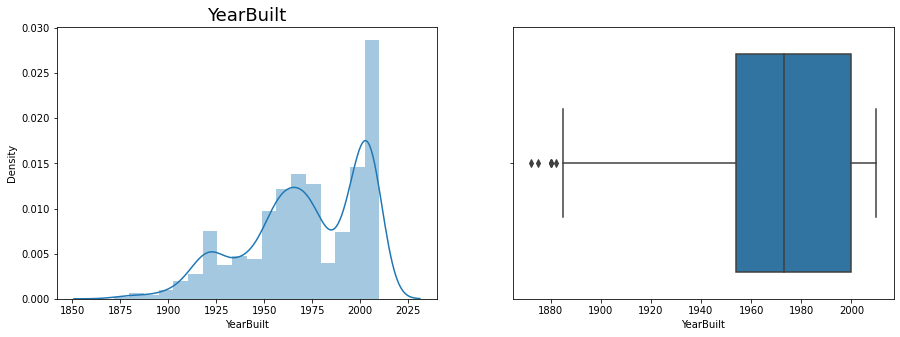

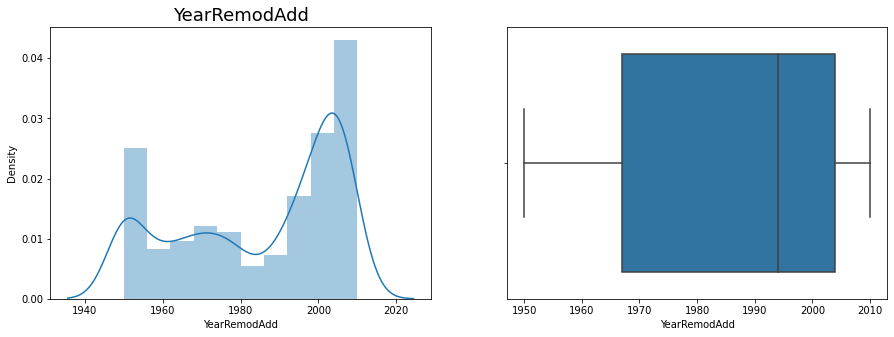

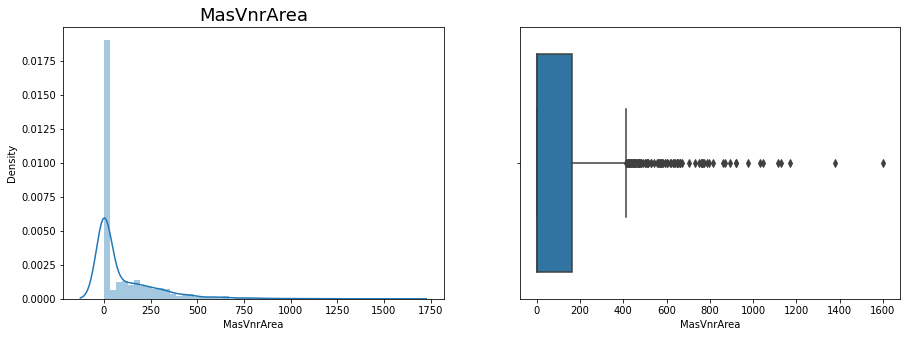

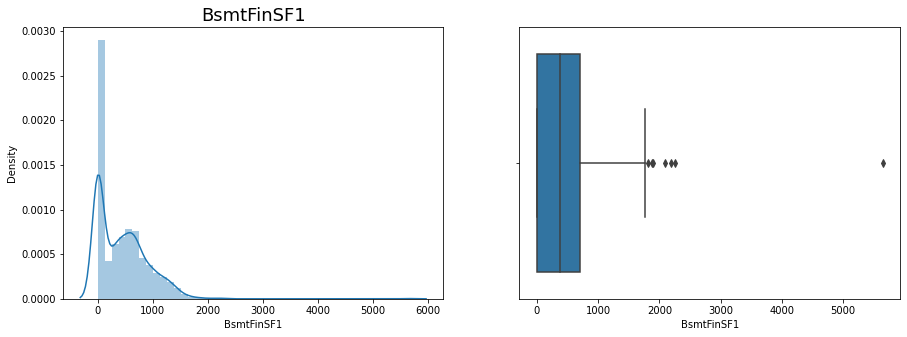

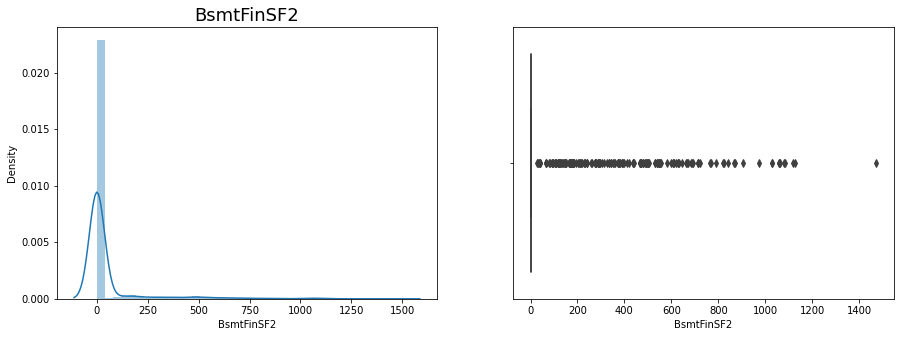

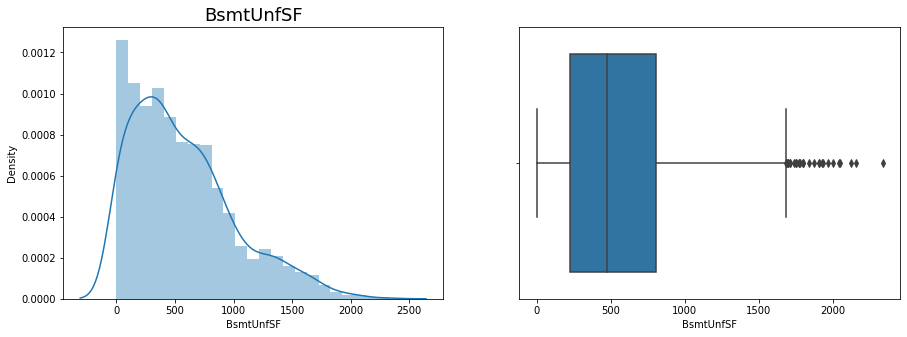

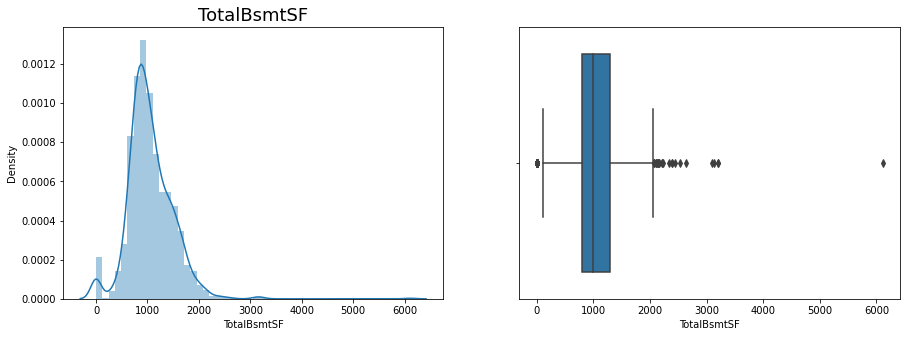

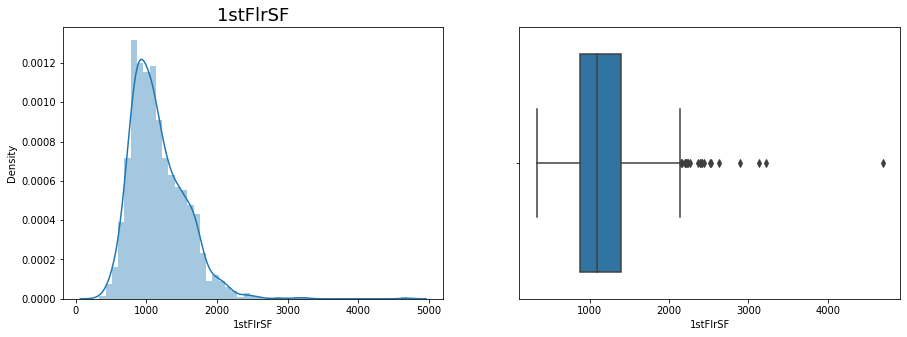

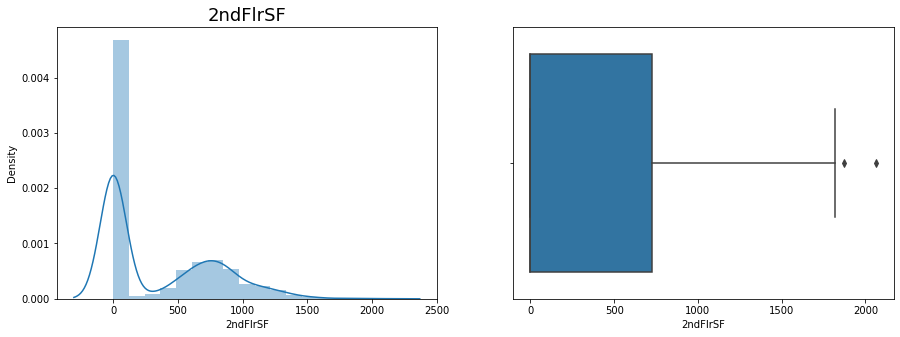

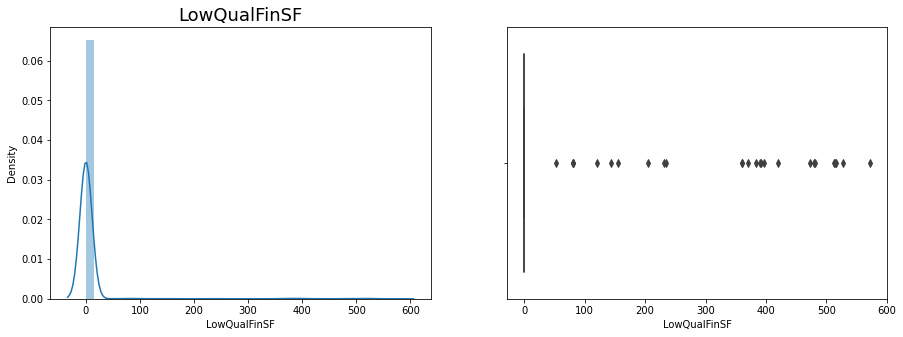

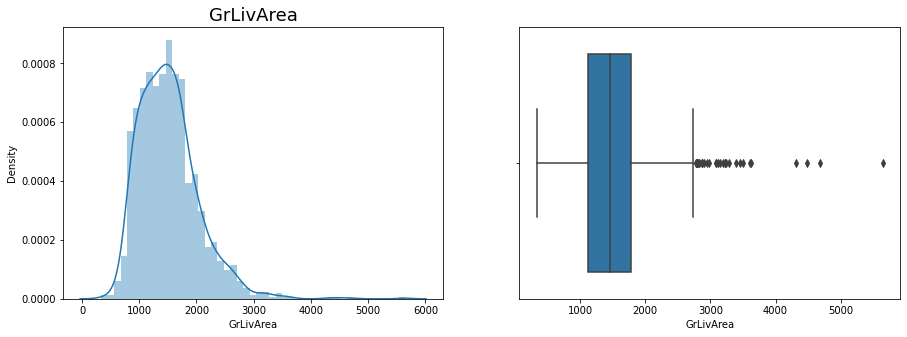

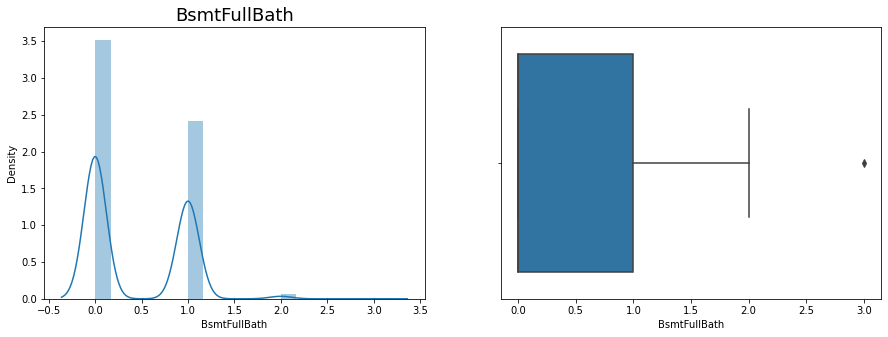

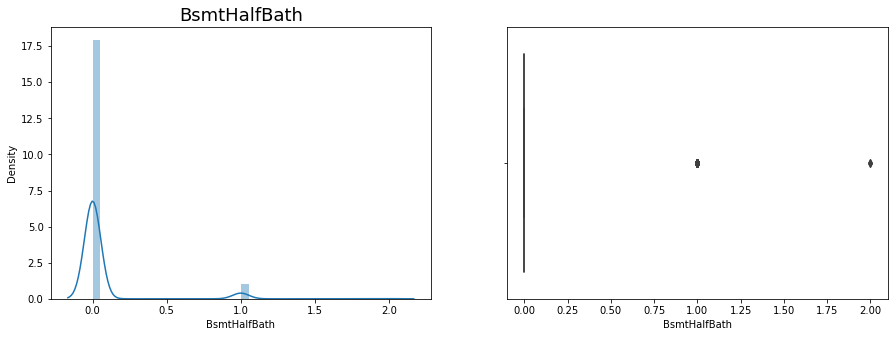

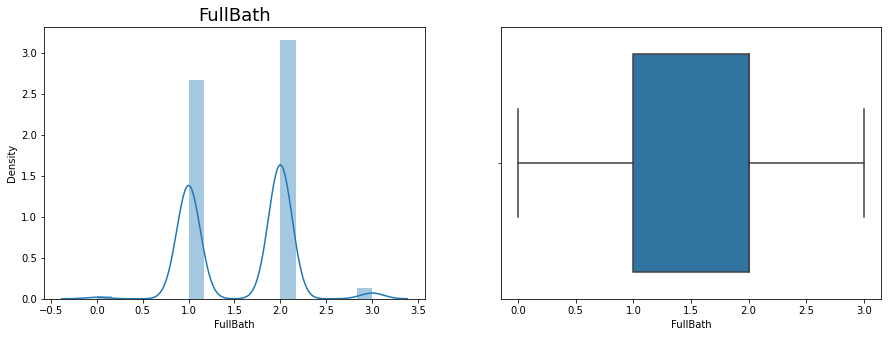

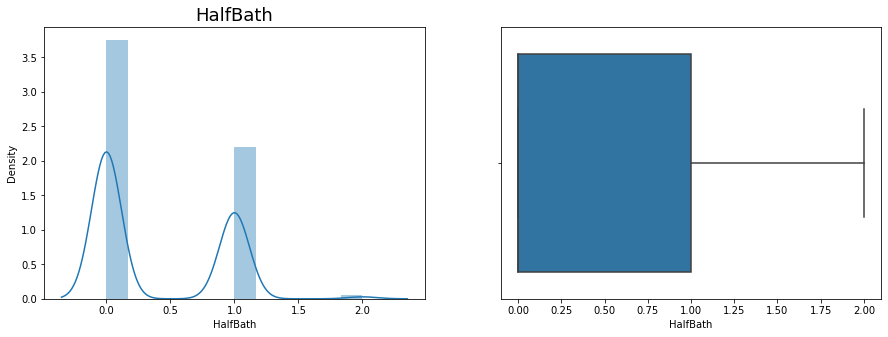

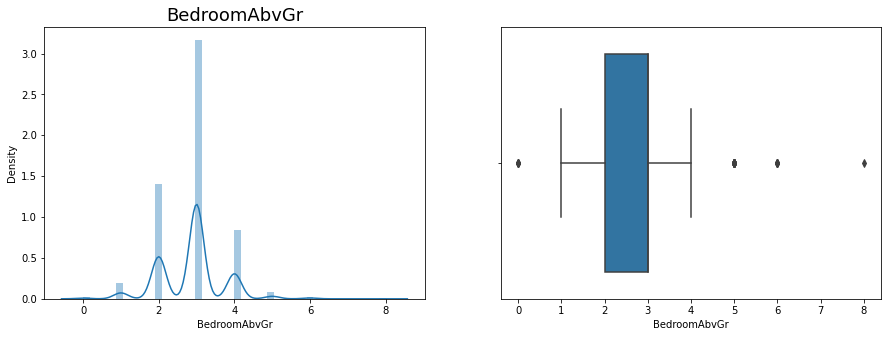

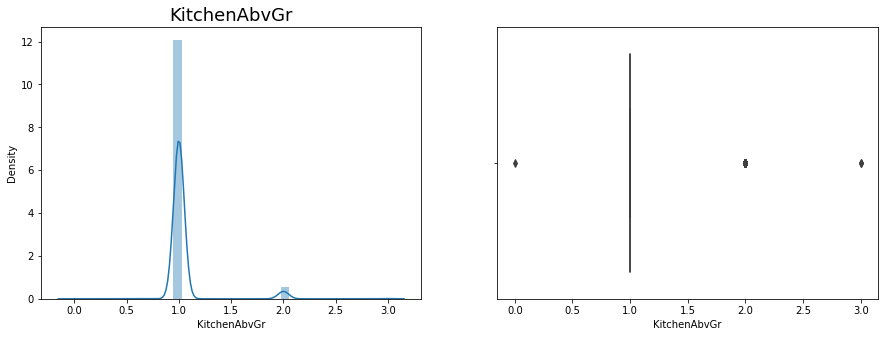

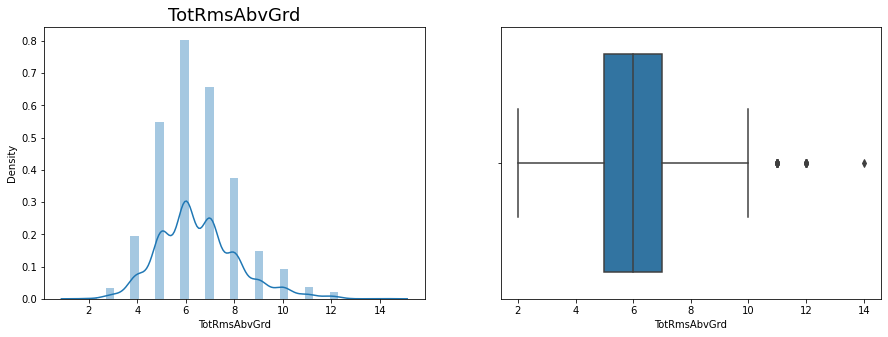

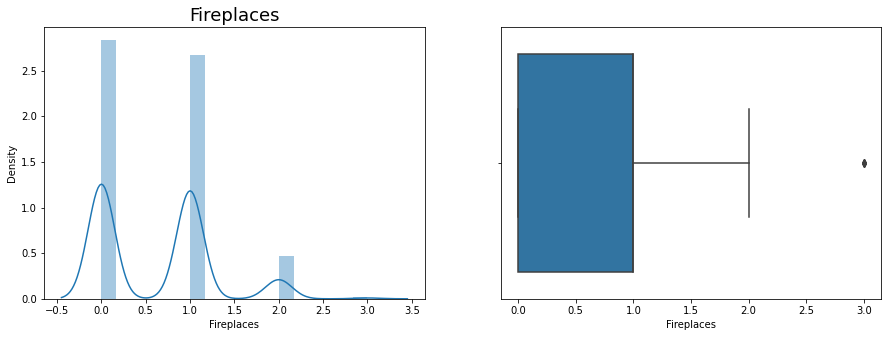

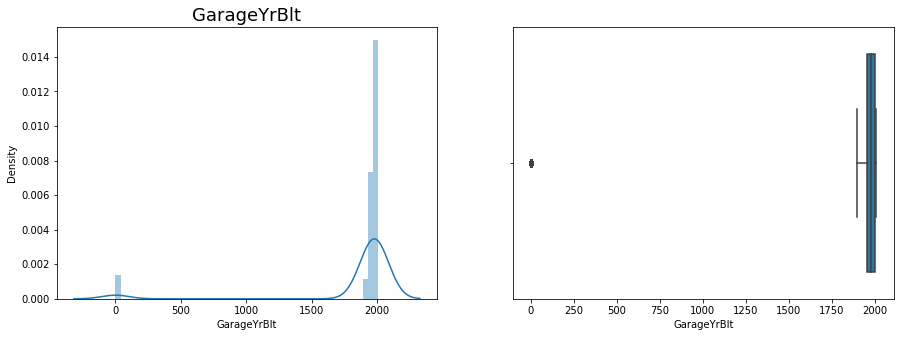

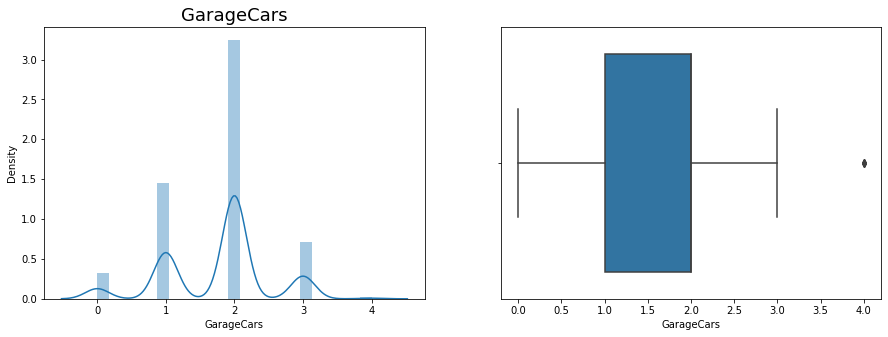

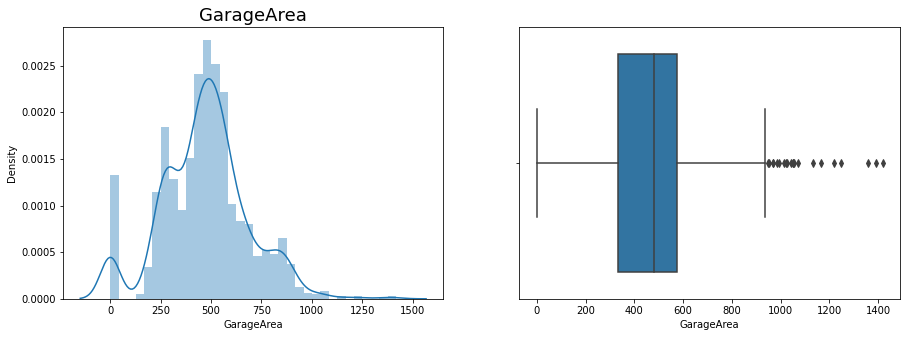

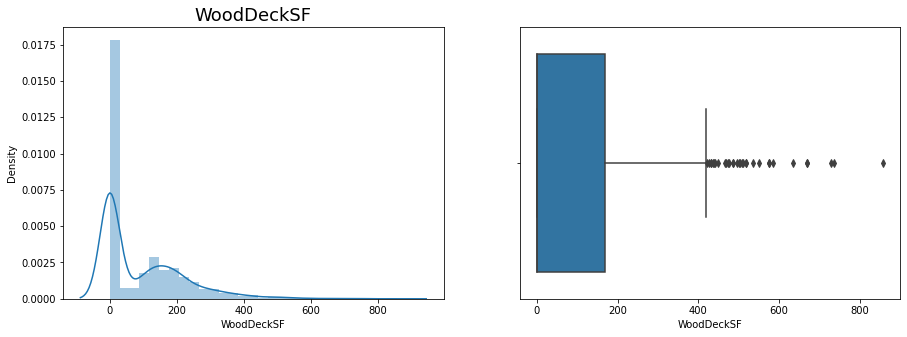

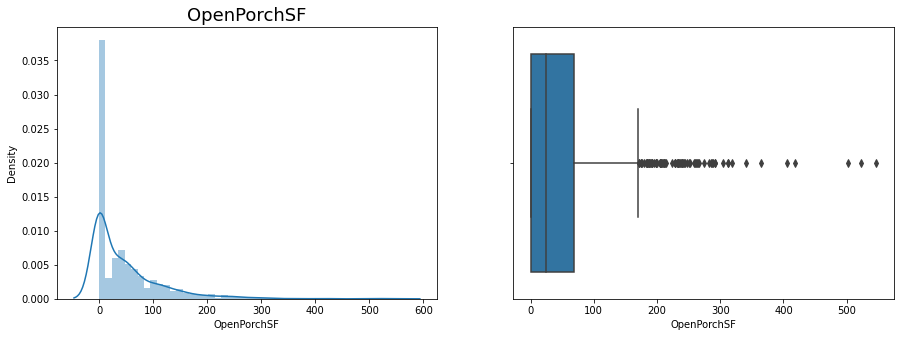

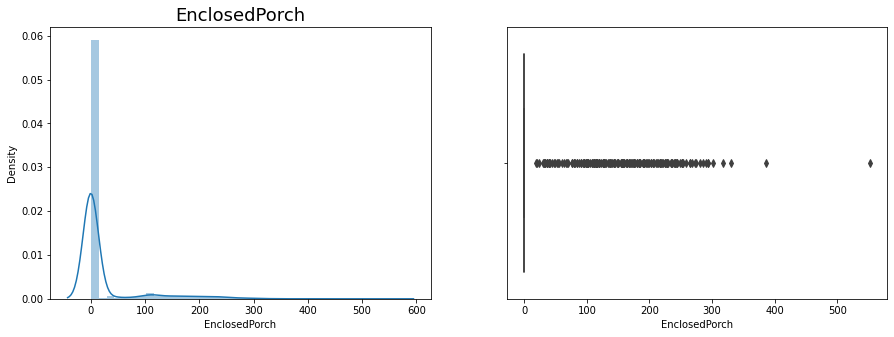

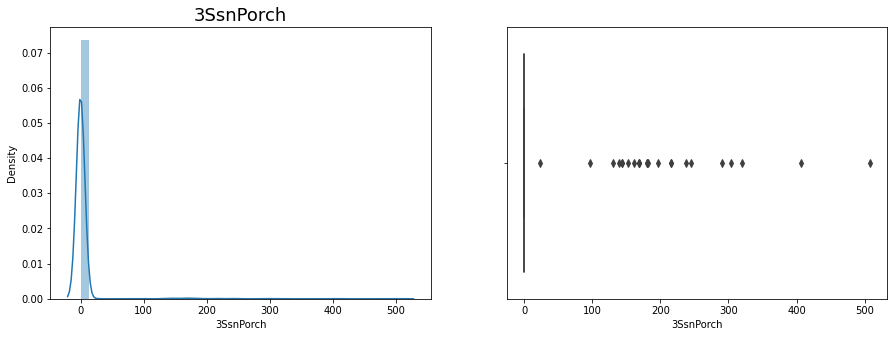

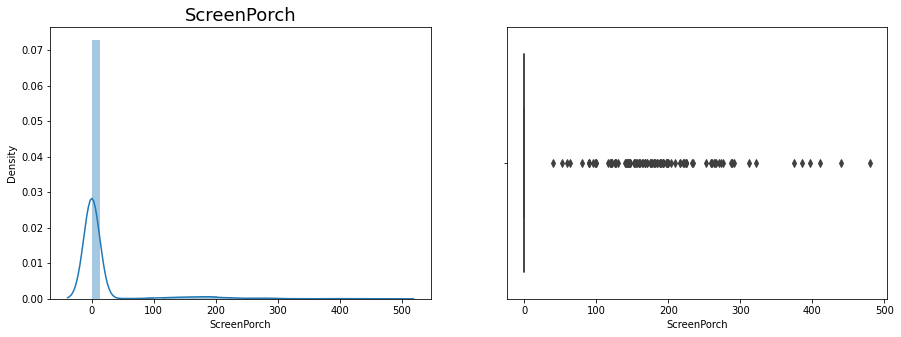

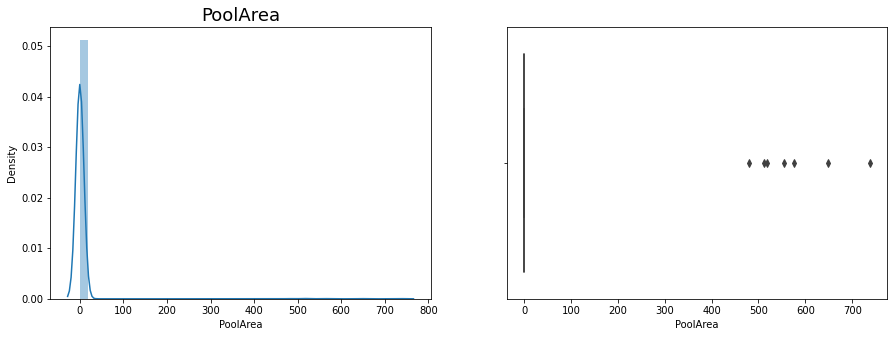

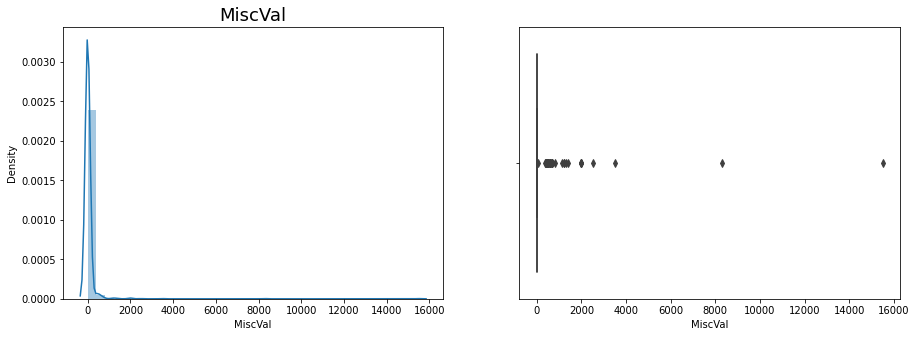

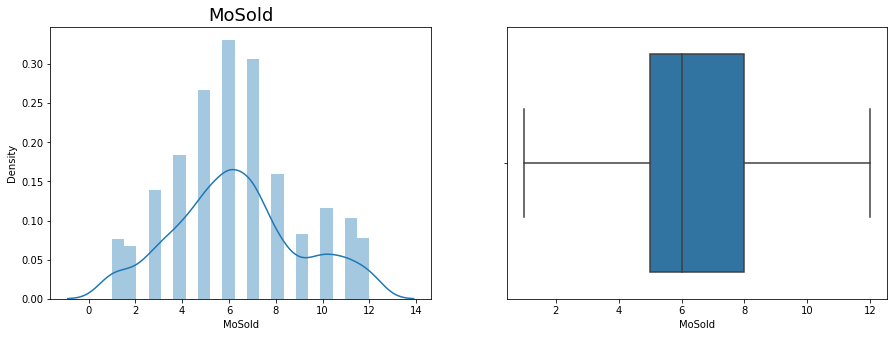

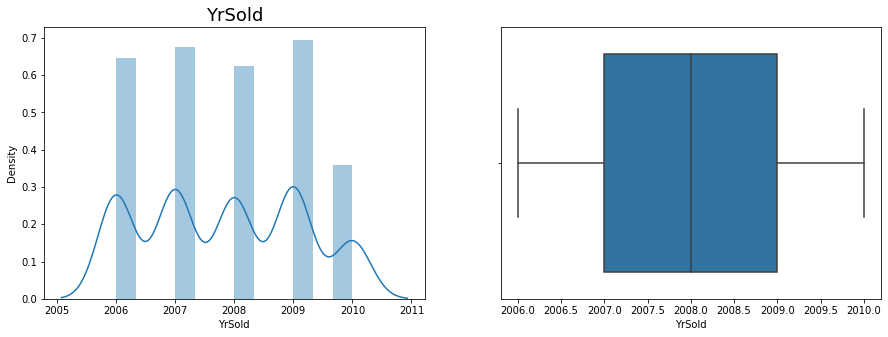

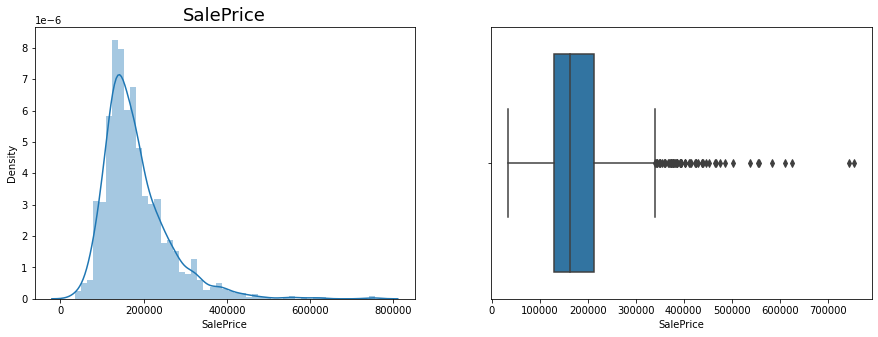

In [382]:
numerical_columns = housing.select_dtypes(include=['number']).columns

for col in numerical_columns:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(col, fontdict={'fontsize': 18})
    sns.distplot(housing[col])
    plt.subplot(1,2,2)
    sns.boxplot(housing[col])
    plt.show() 

Most numerical columns have outliers.

### Visualise categorical columns

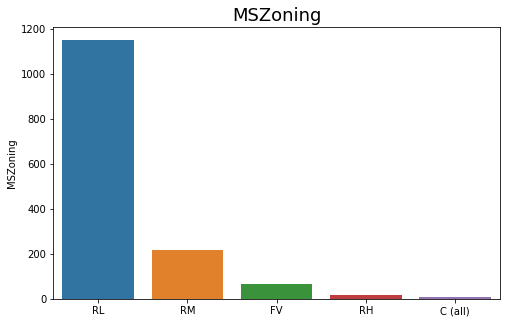

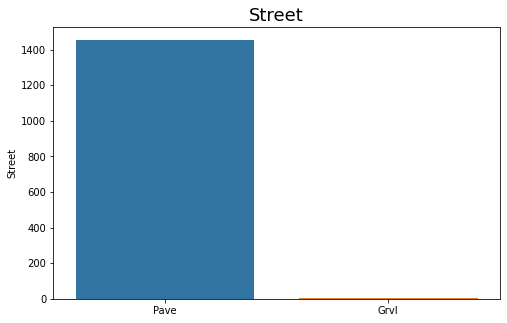

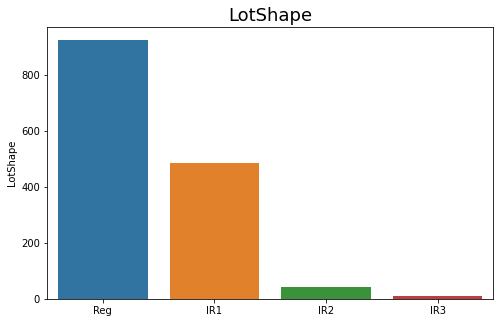

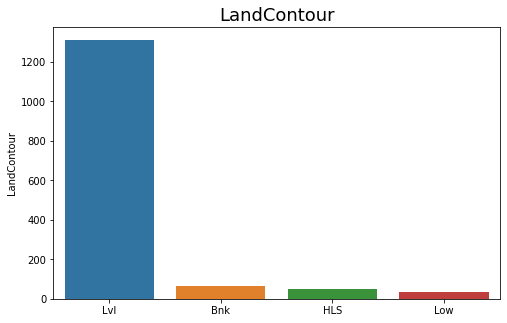

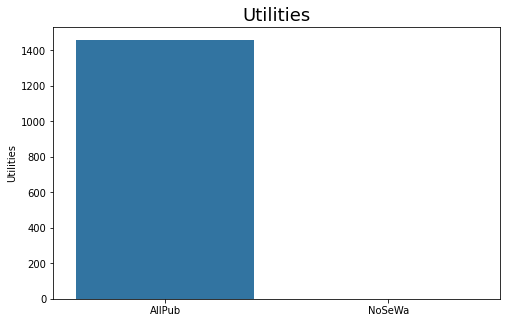

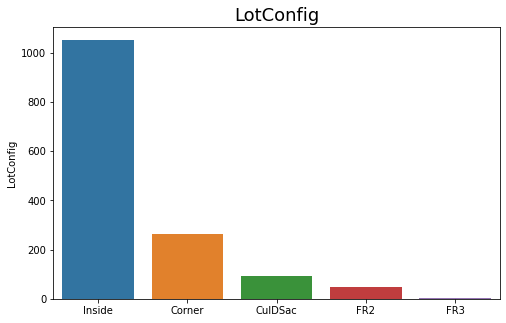

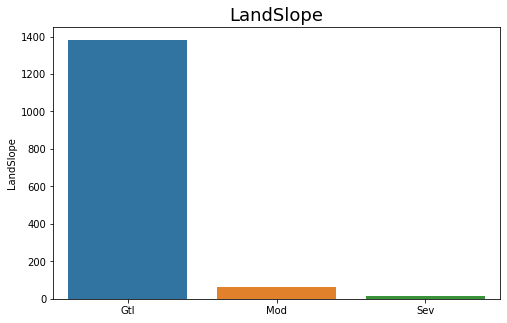

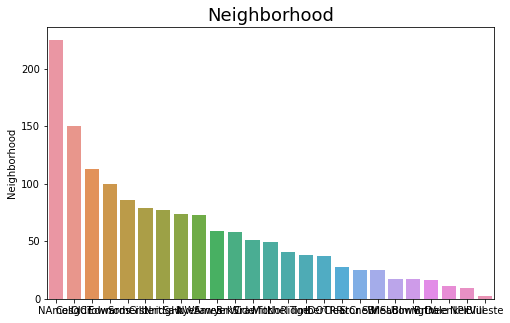

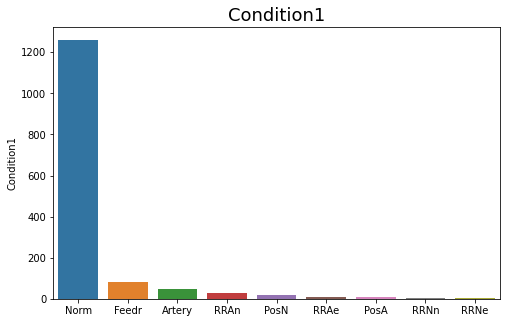

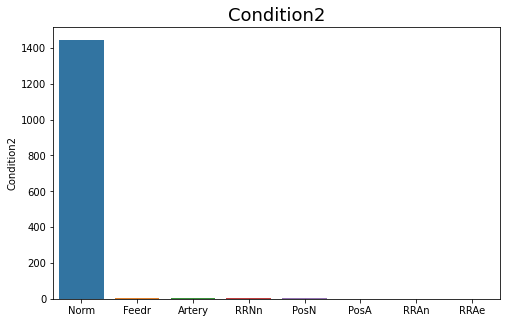

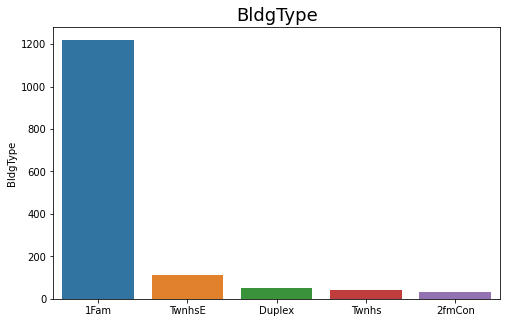

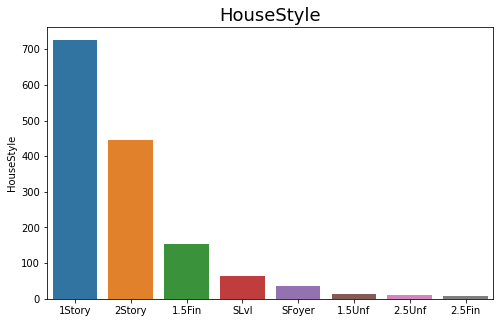

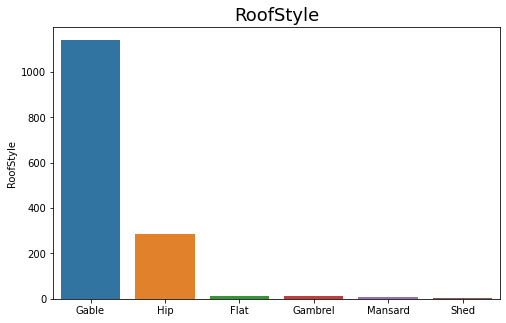

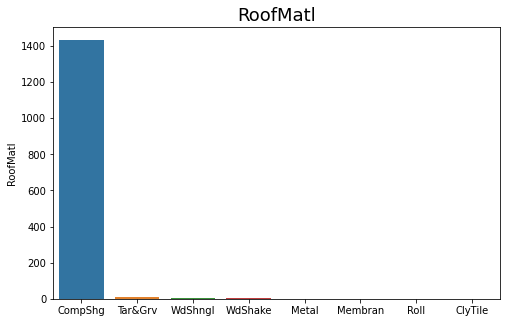

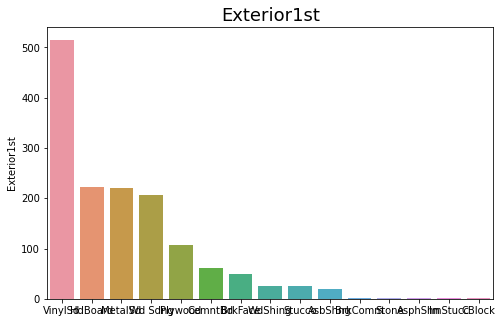

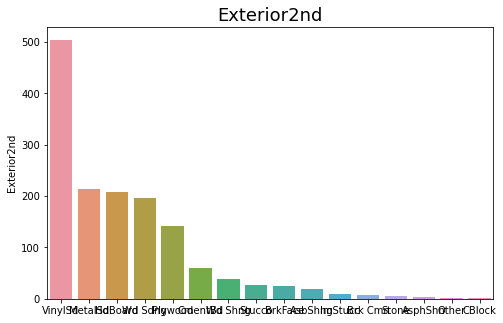

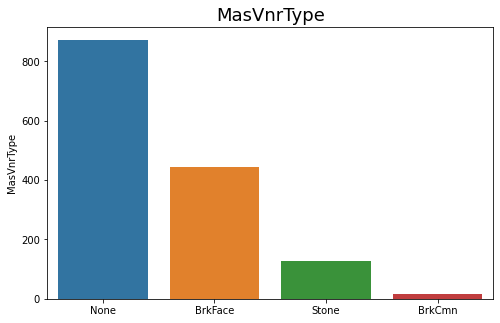

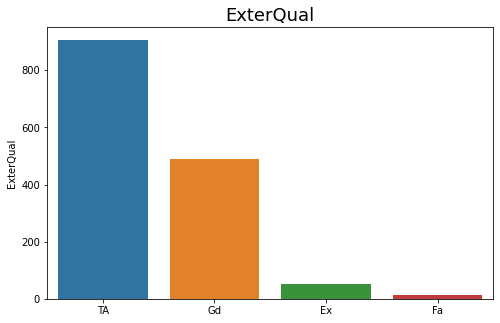

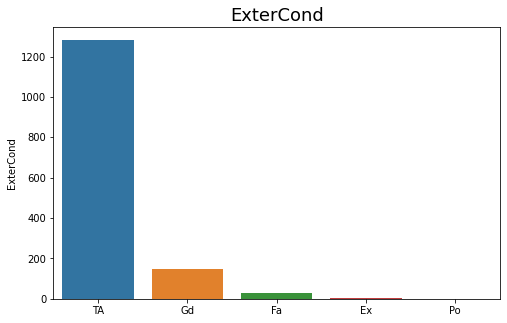

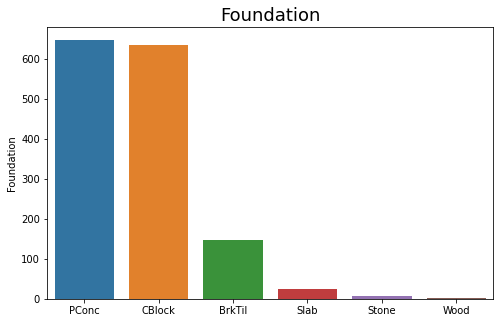

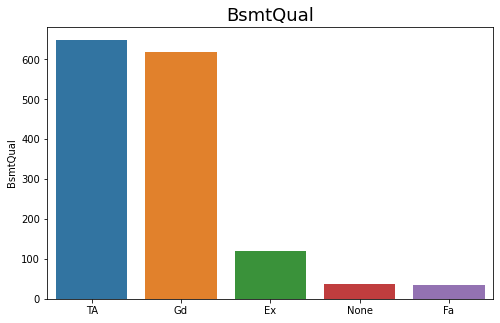

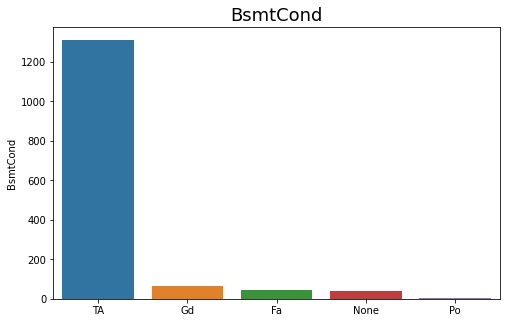

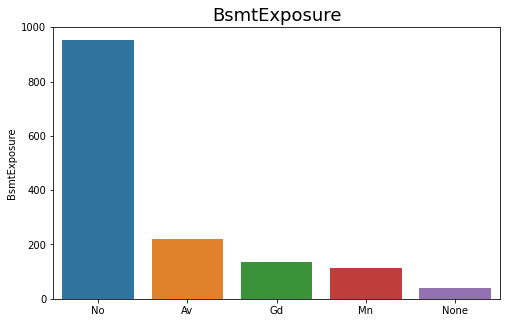

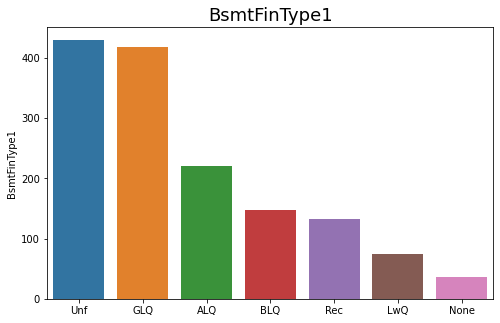

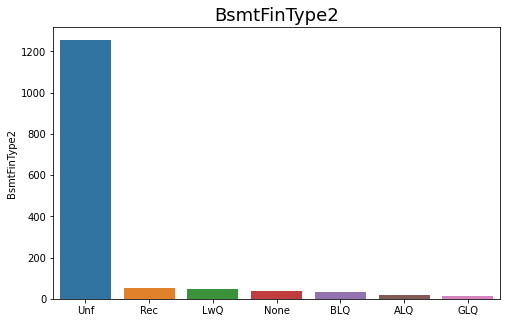

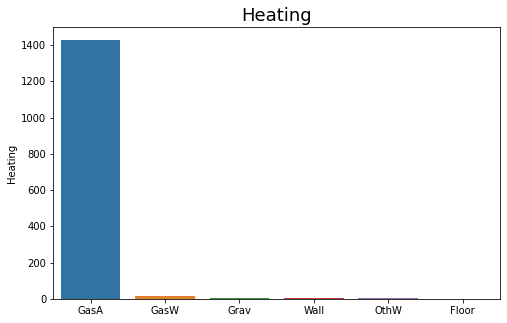

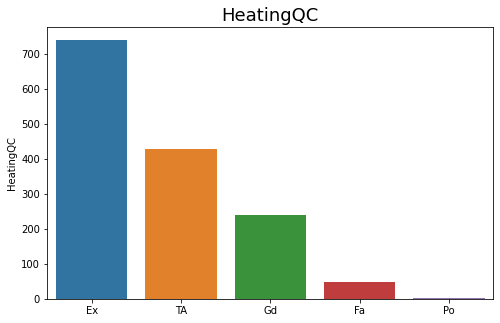

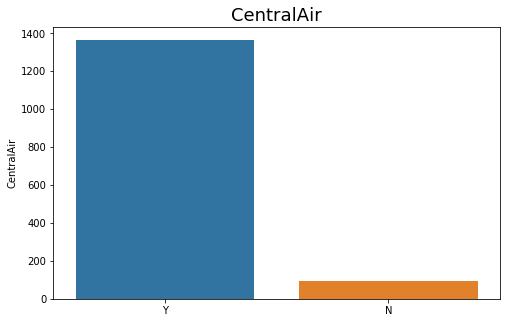

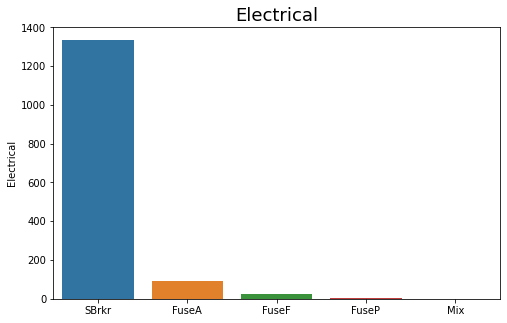

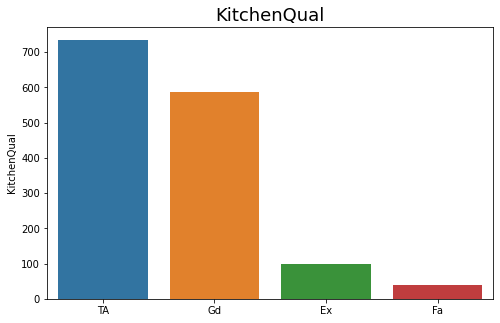

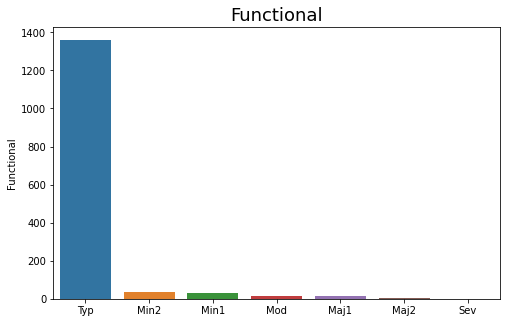

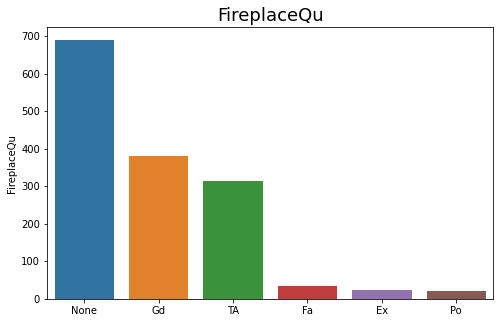

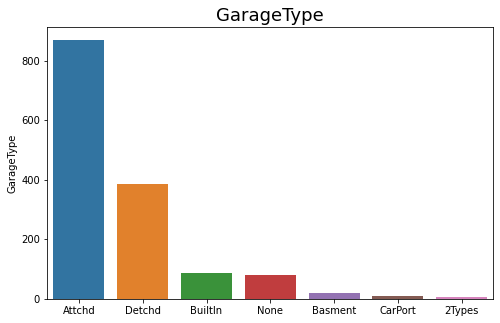

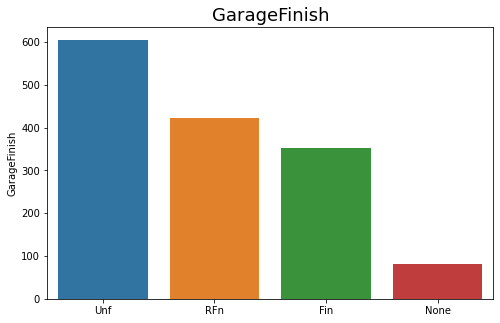

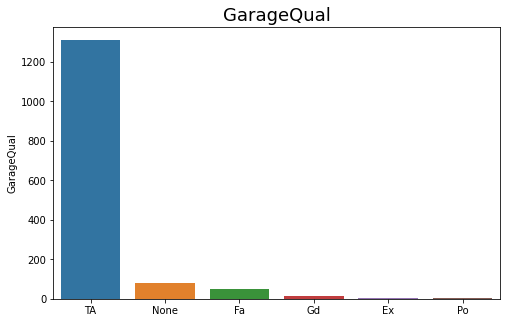

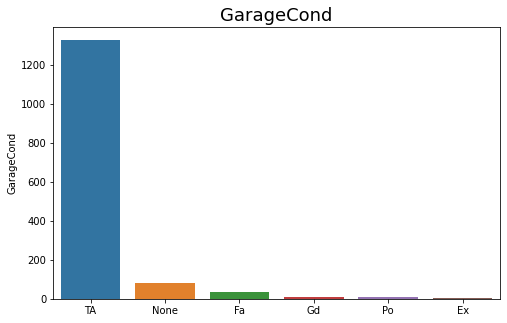

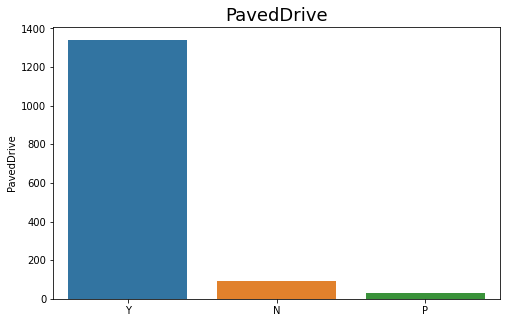

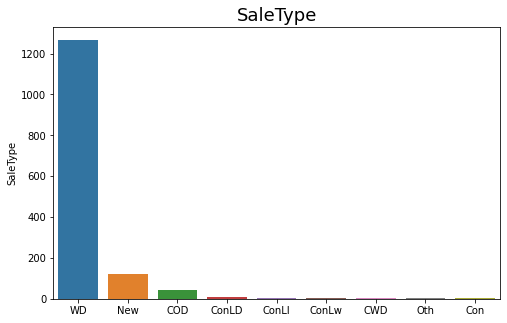

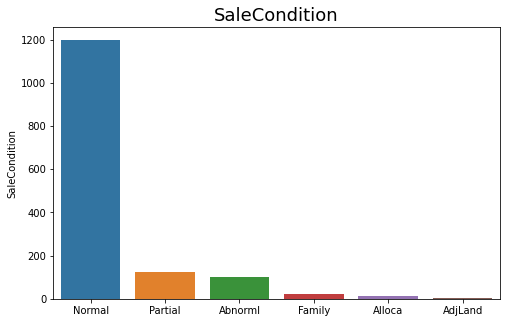

In [383]:
cat_columns = housing.select_dtypes(include=['object']).columns
for col in cat_columns:
    plt.figure(figsize=(8,5))
    plt.title(col, fontdict={'fontsize': 18})
    sns.barplot(housing[col].value_counts().index, housing[col].value_counts())
    plt.show()

Inference - Values of categorical columns are distributed across multiple categories. Cannot remove any columns.

In [384]:
housing['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

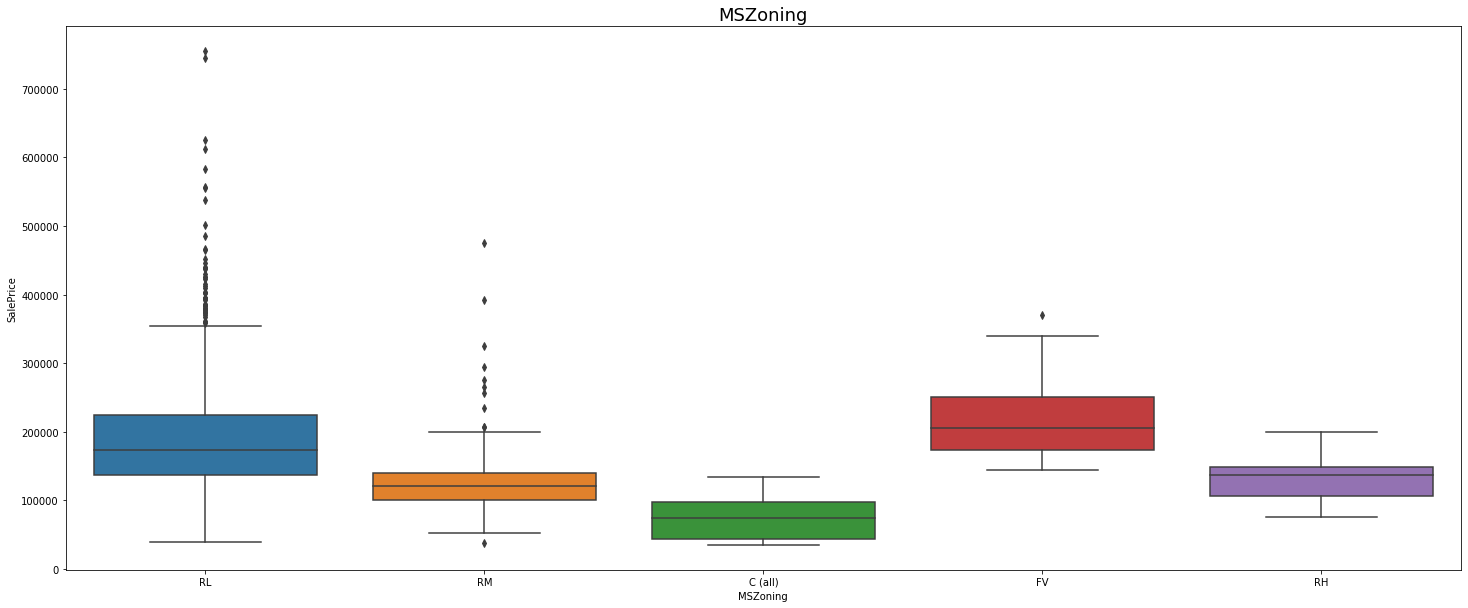

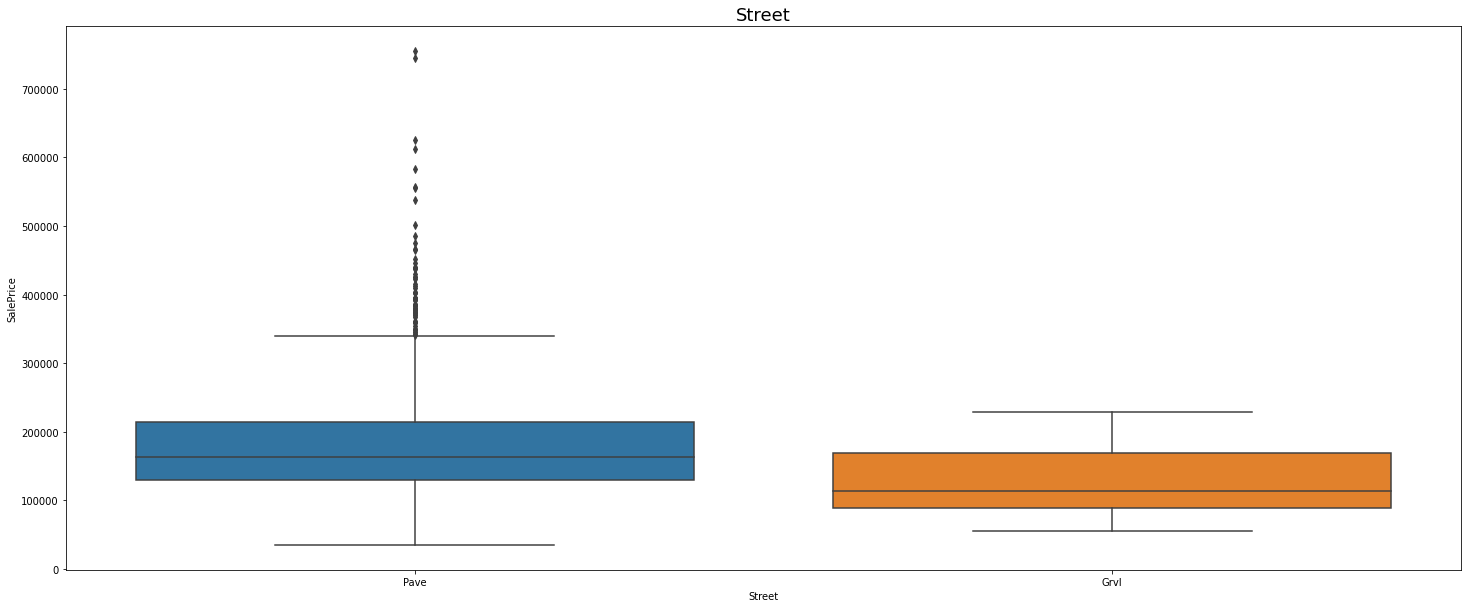

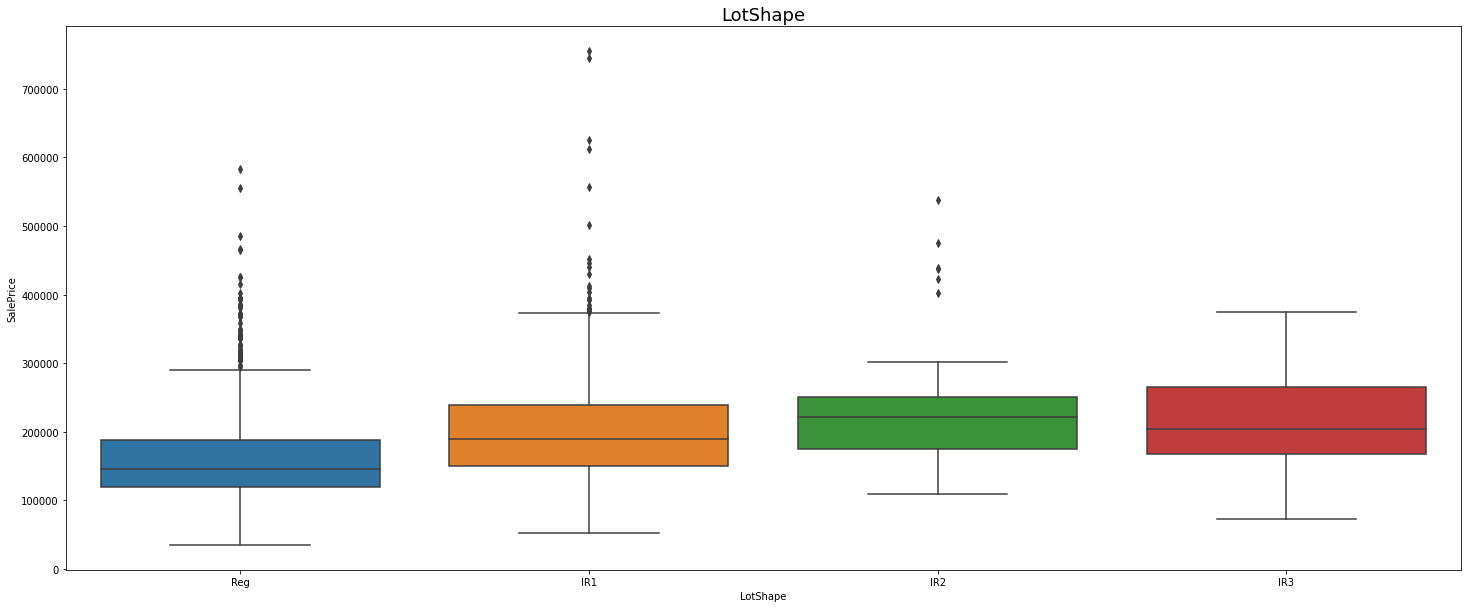

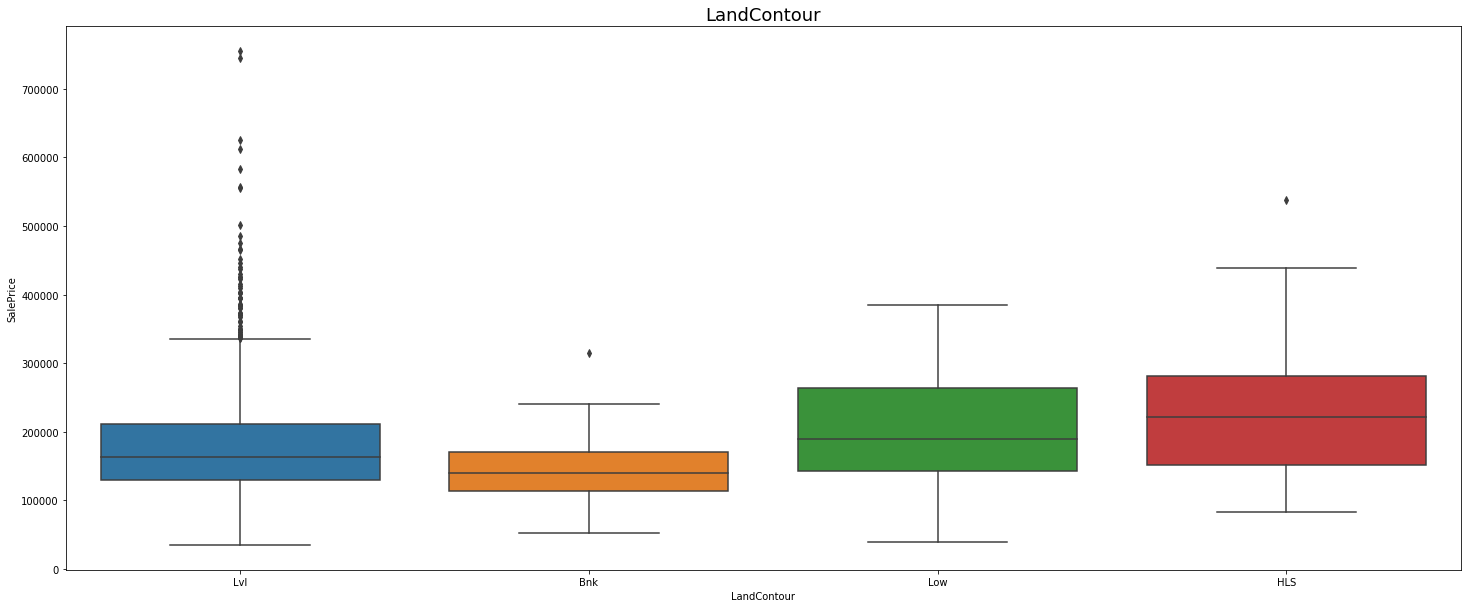

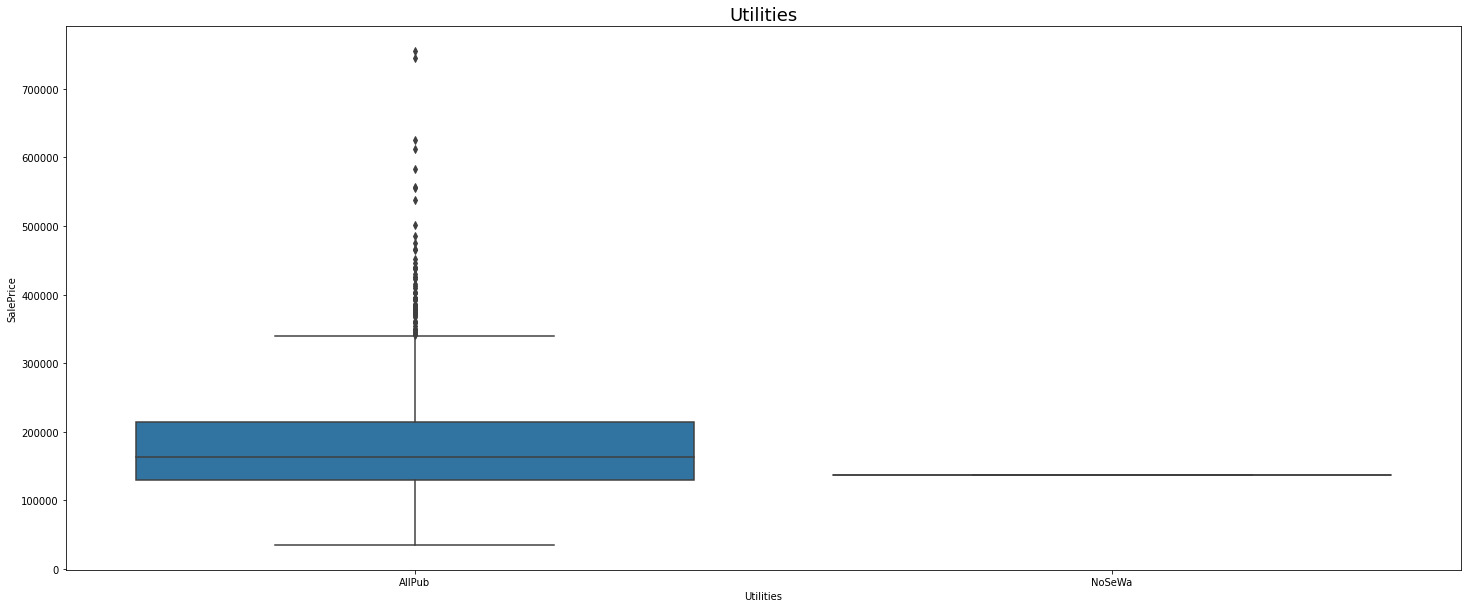

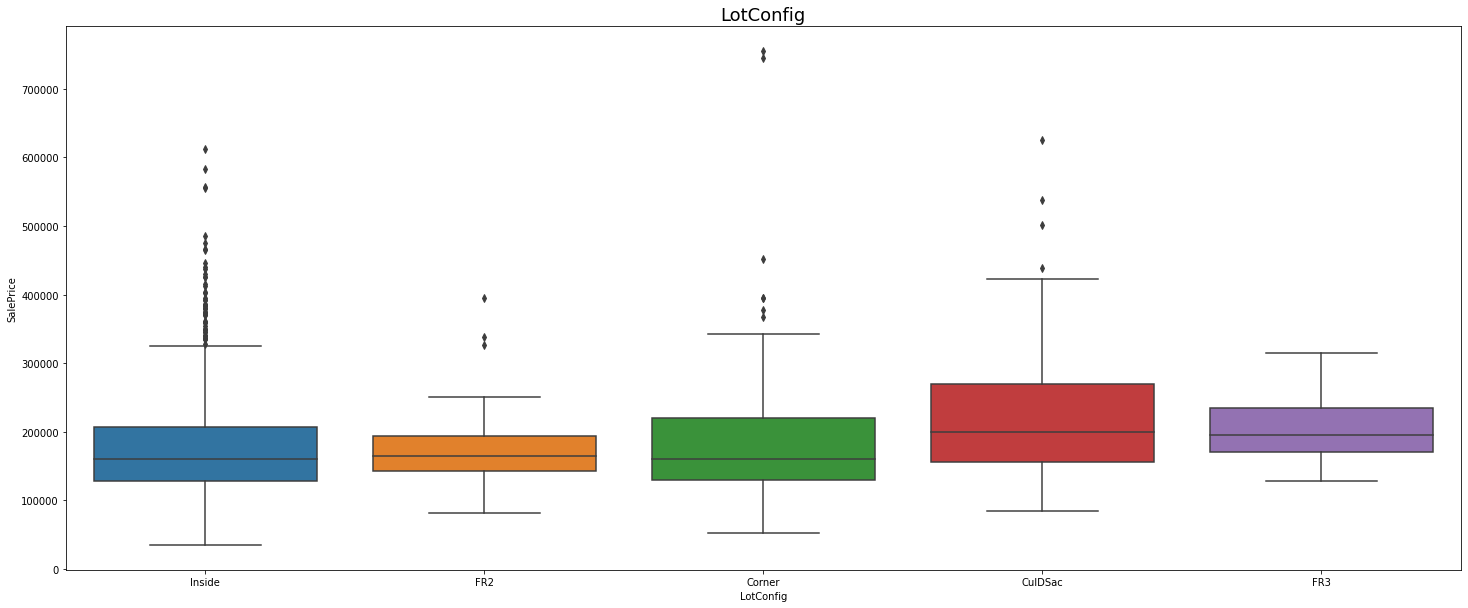

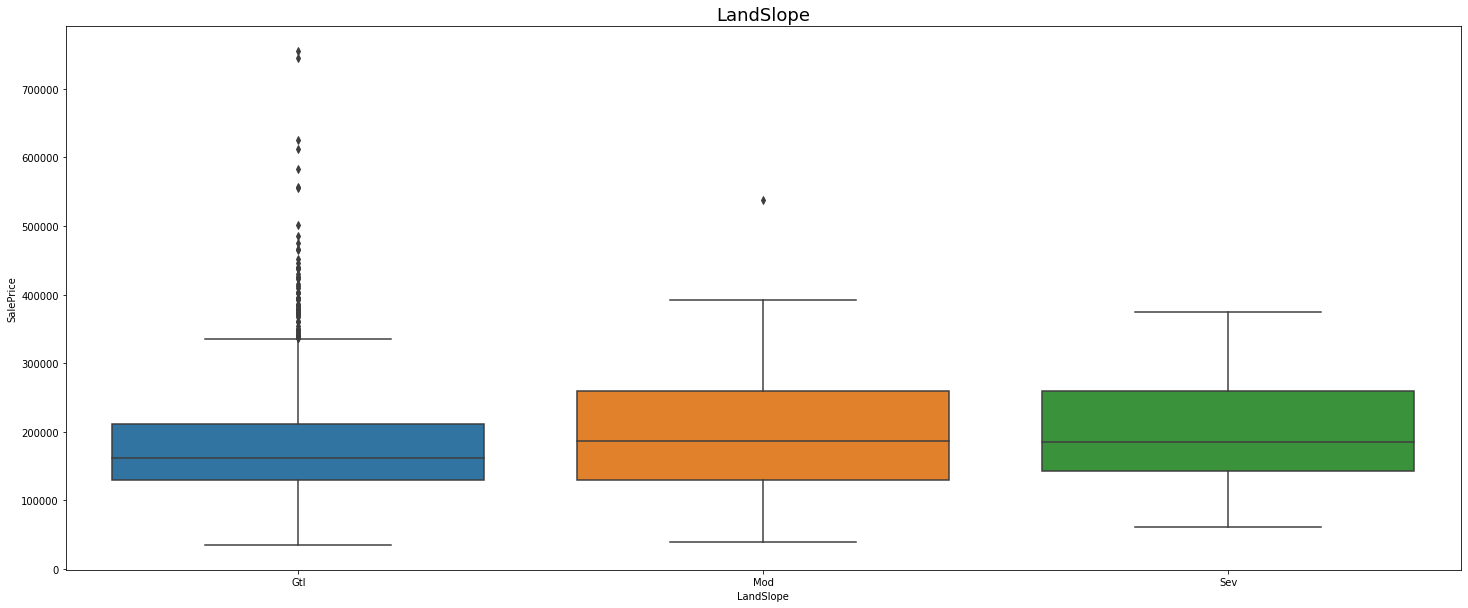

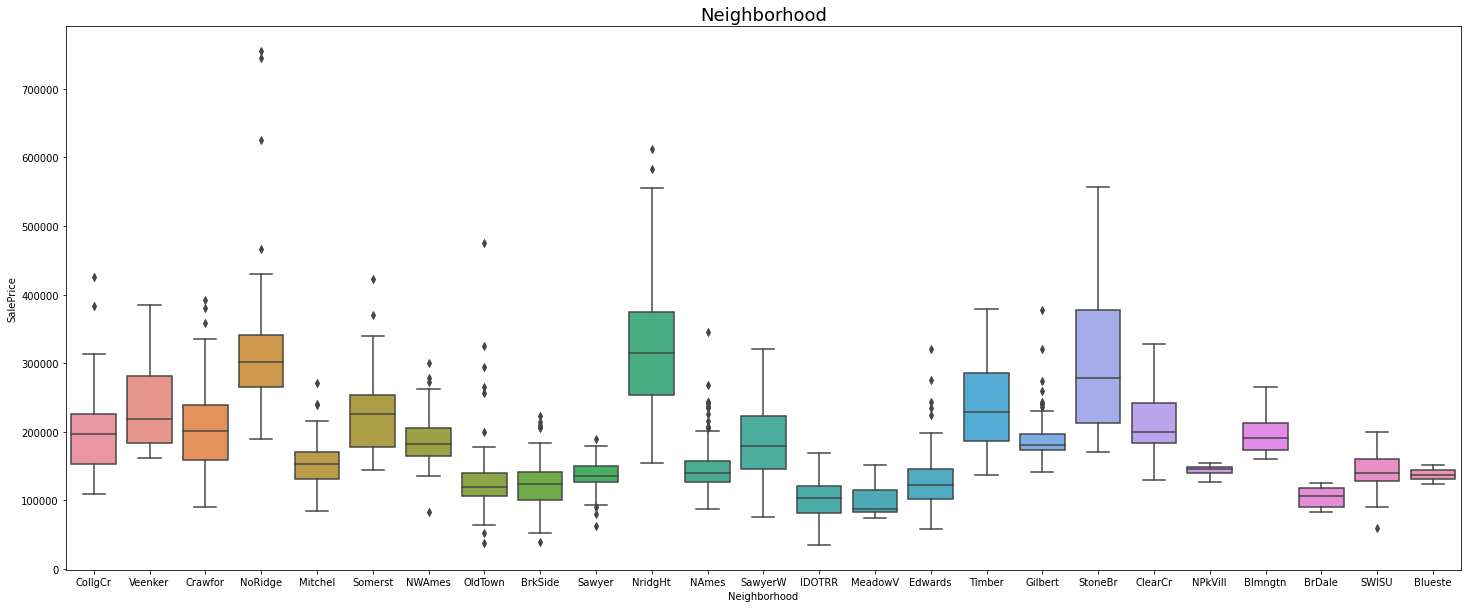

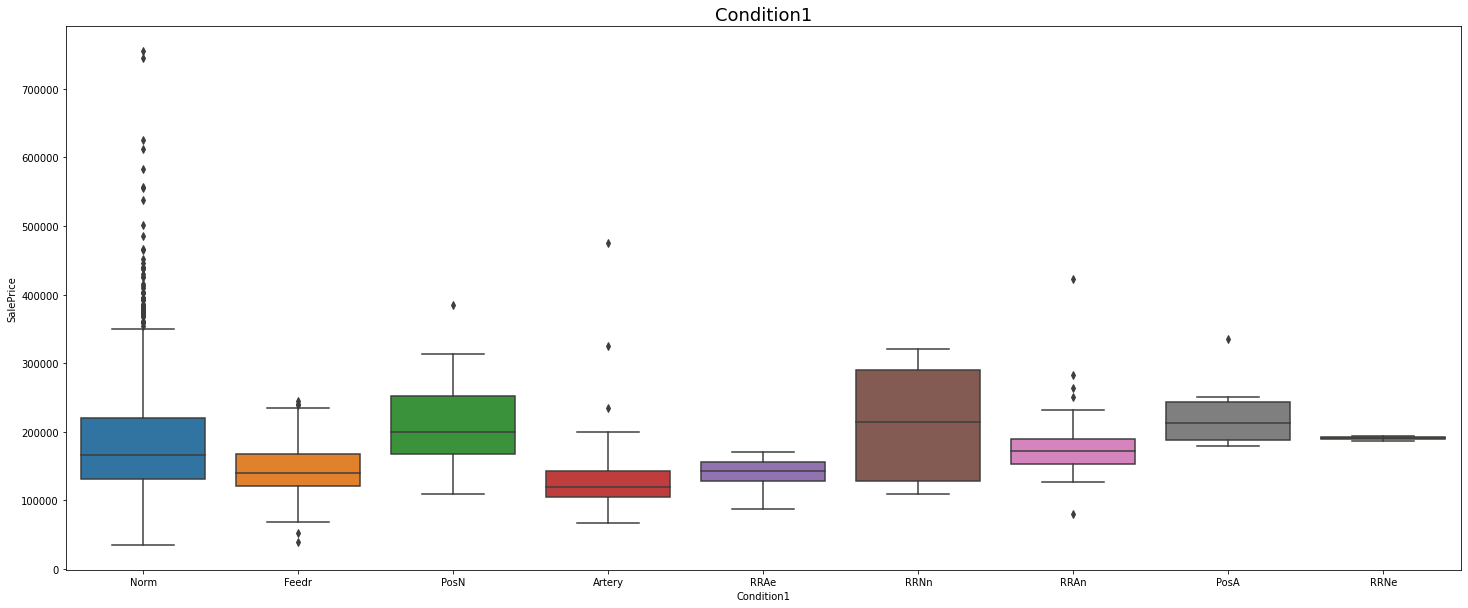

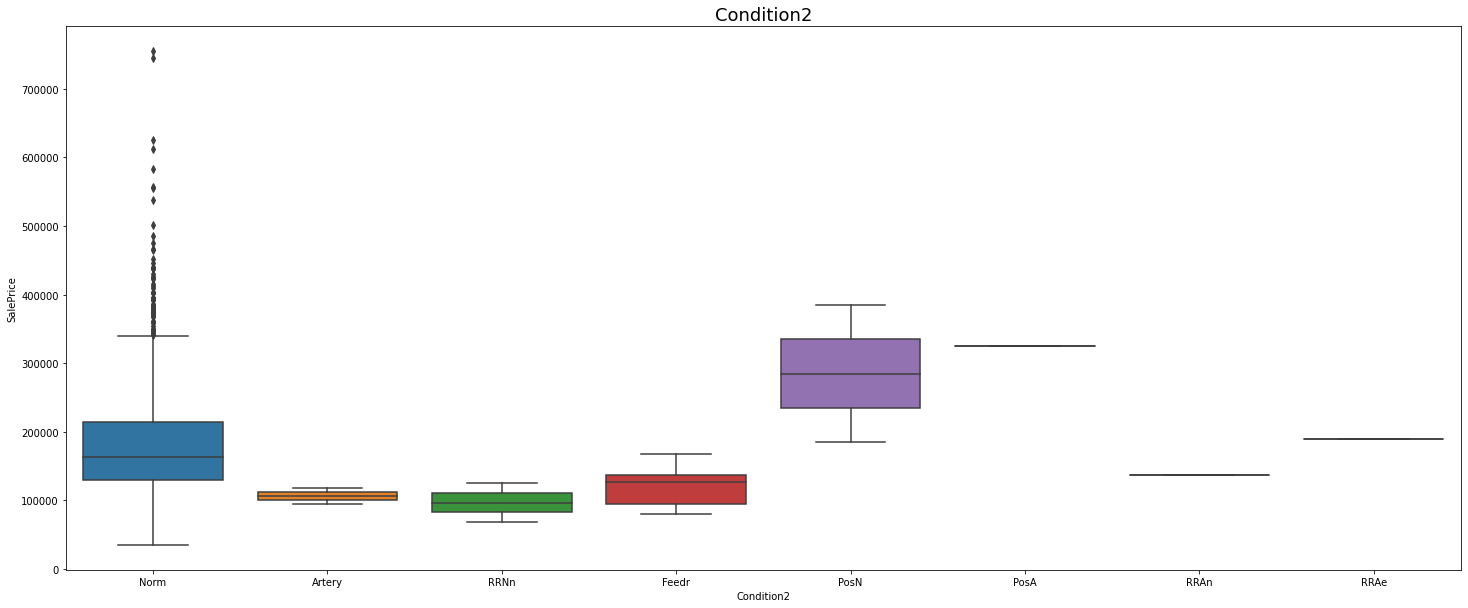

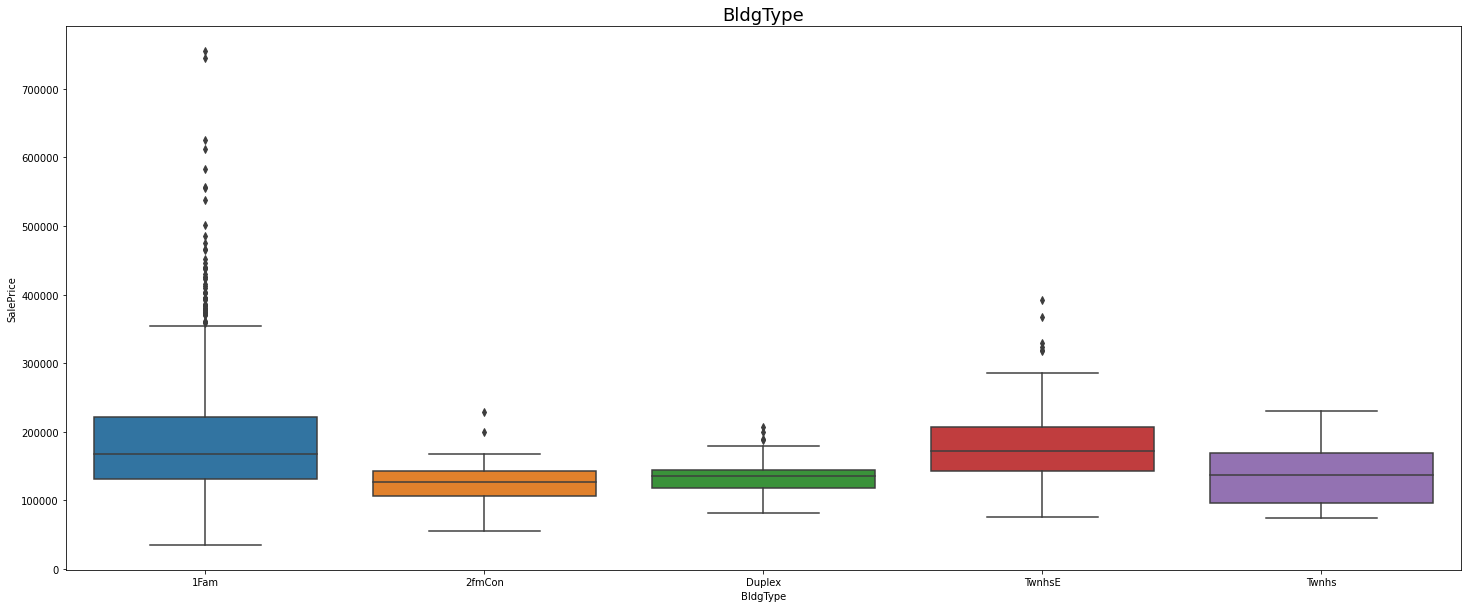

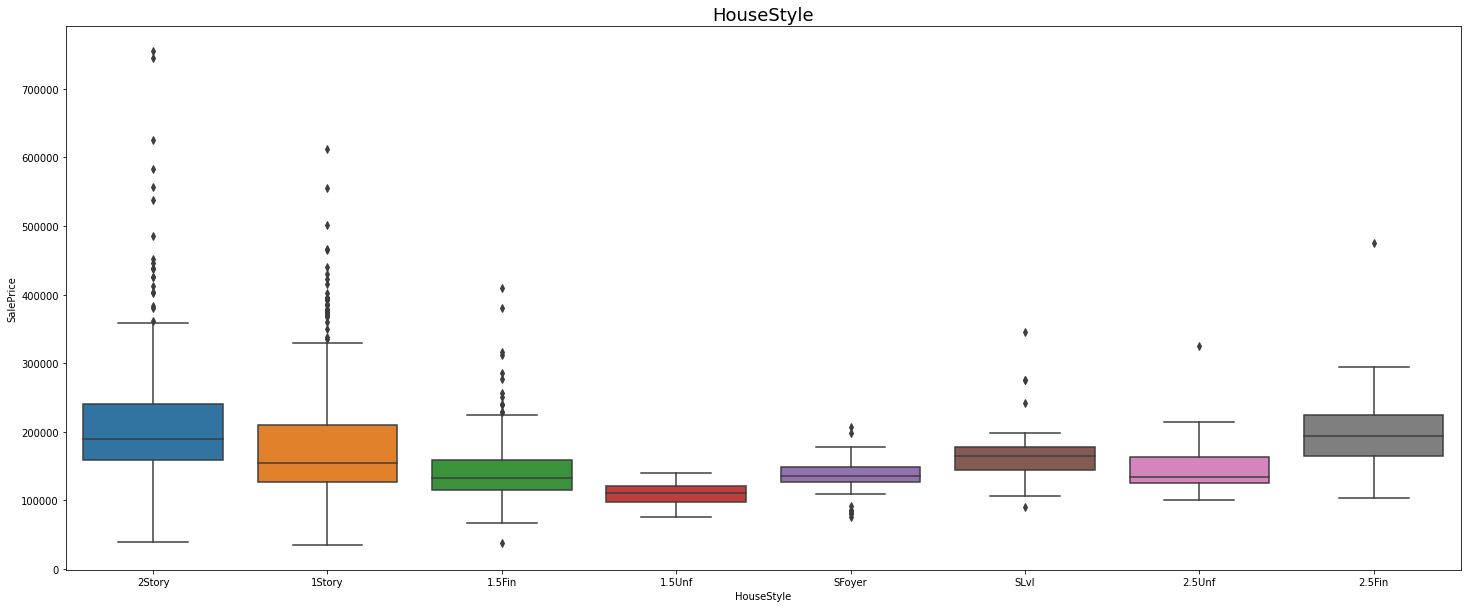

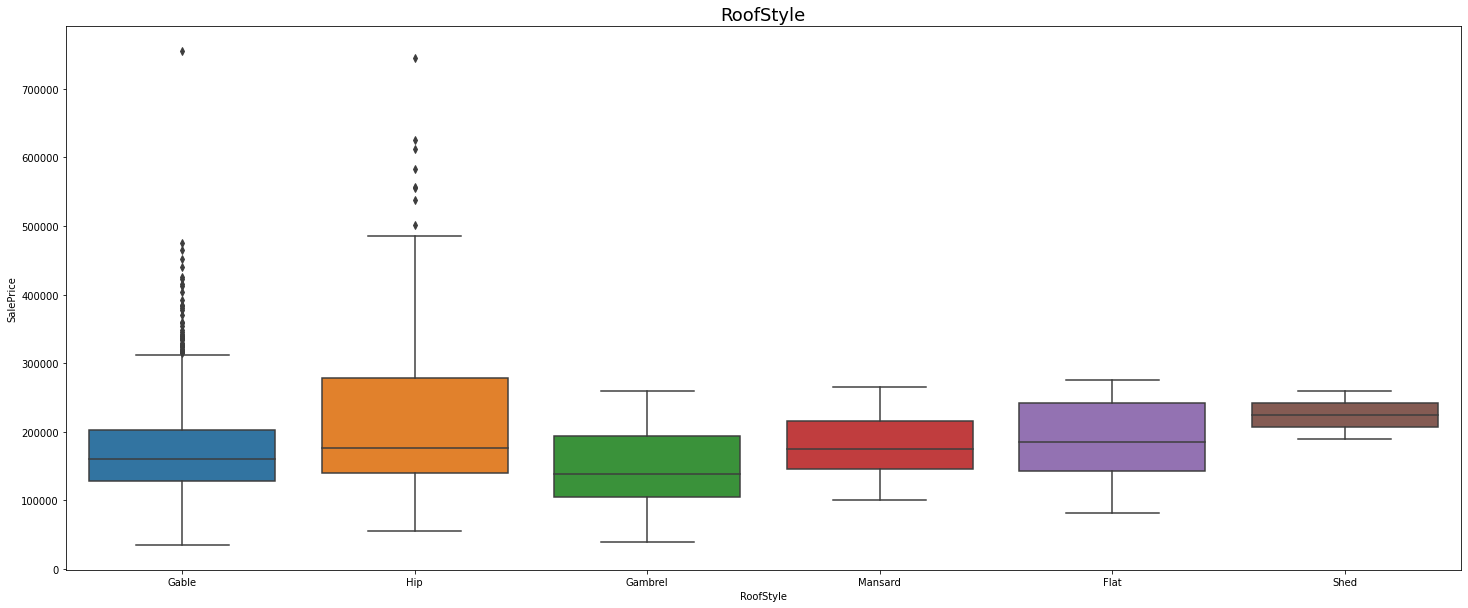

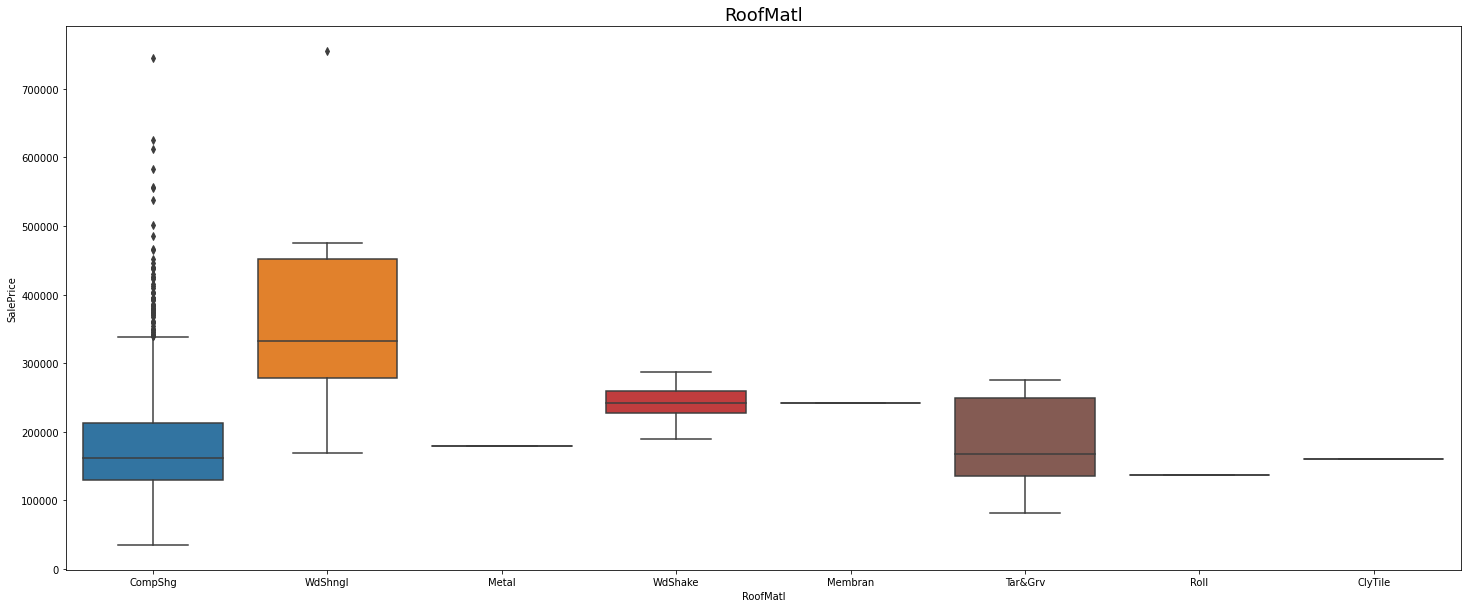

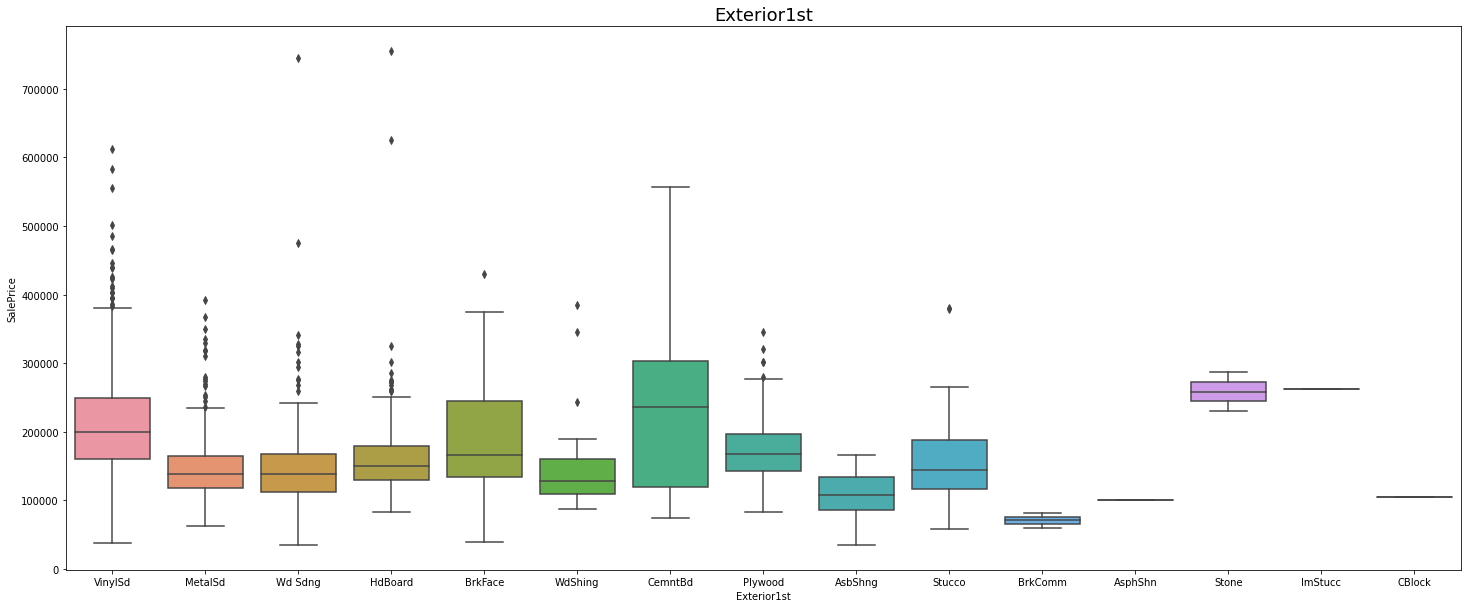

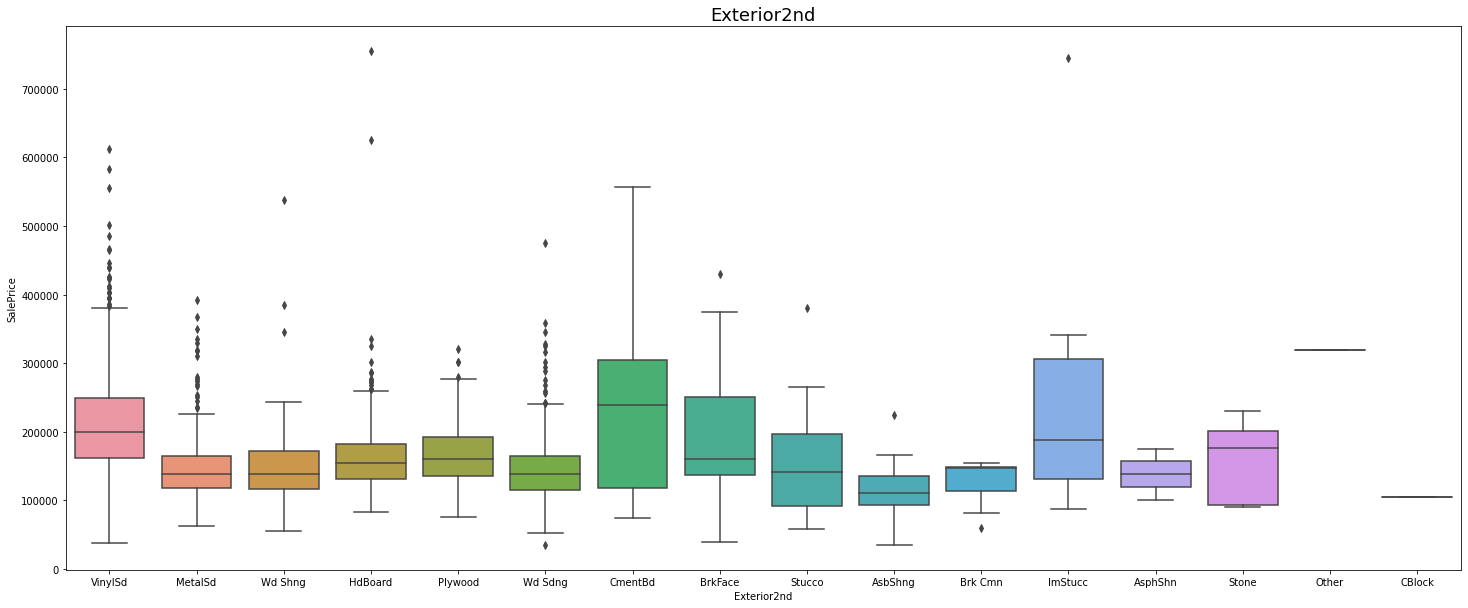

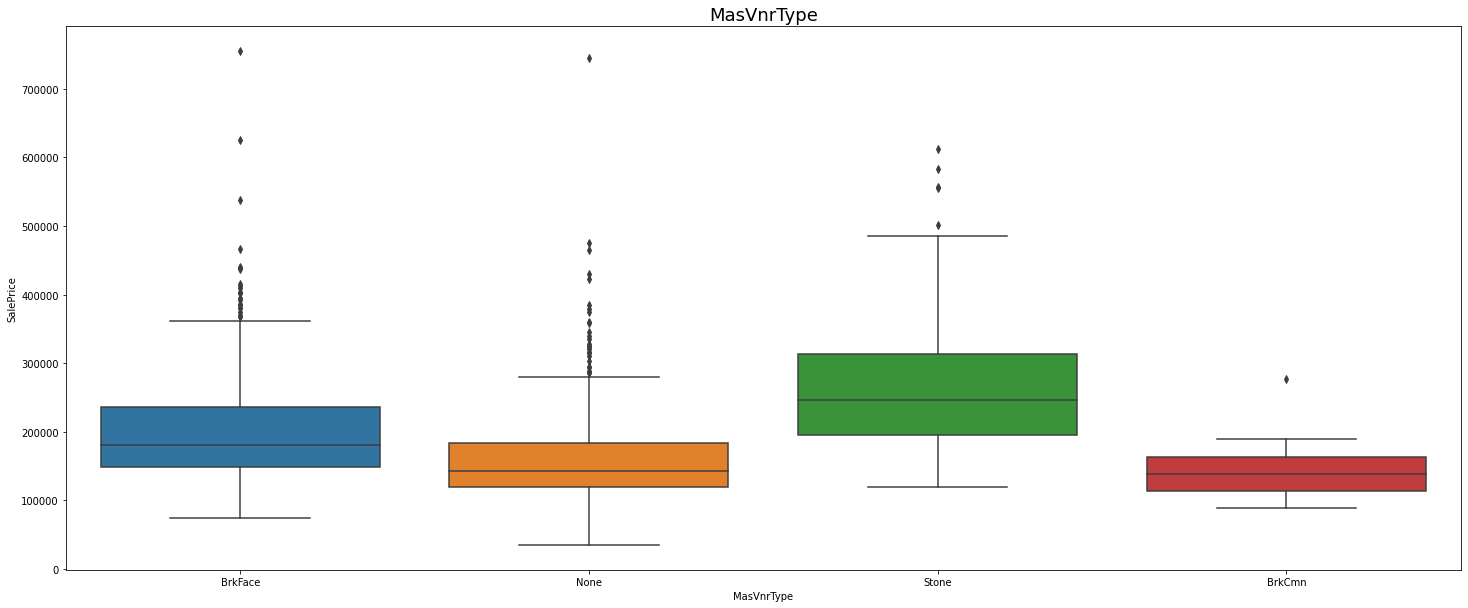

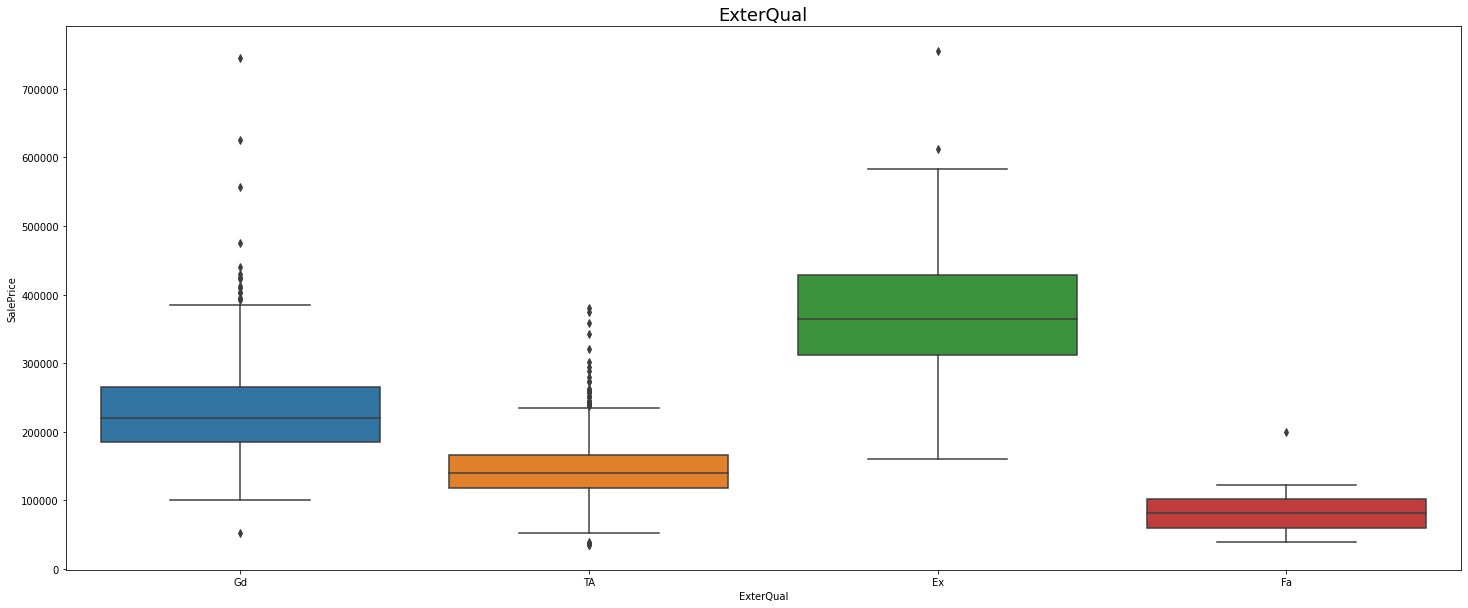

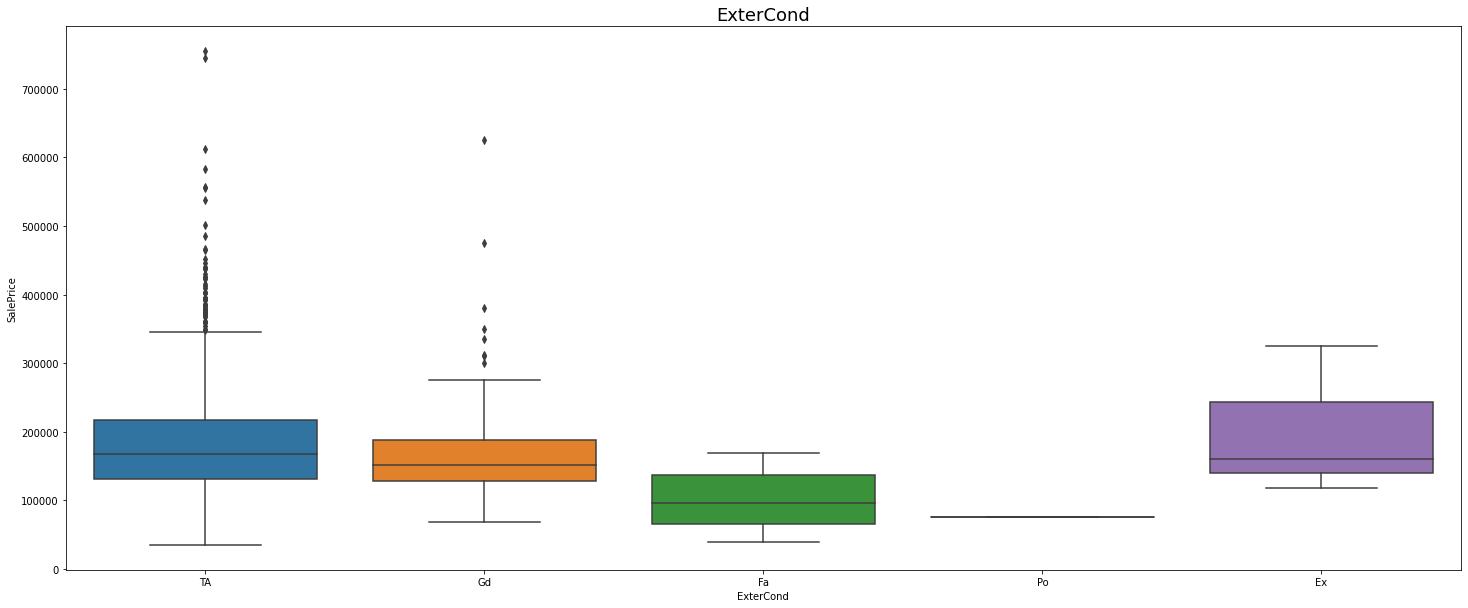

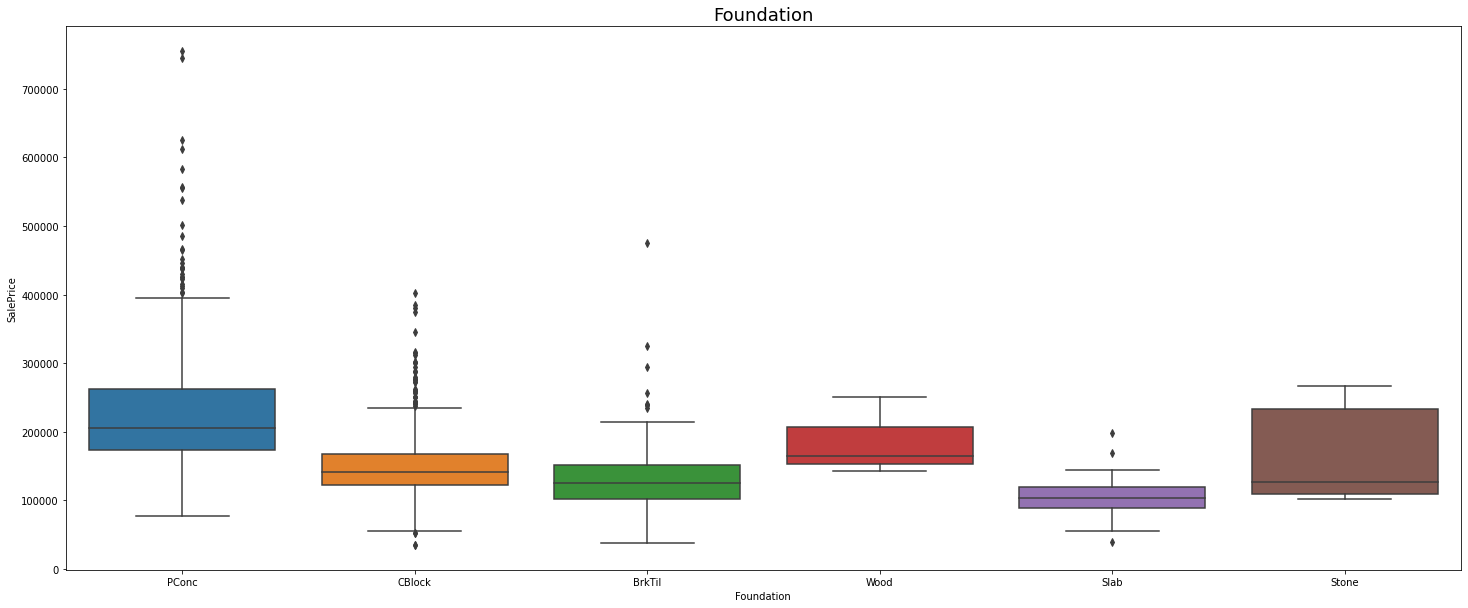

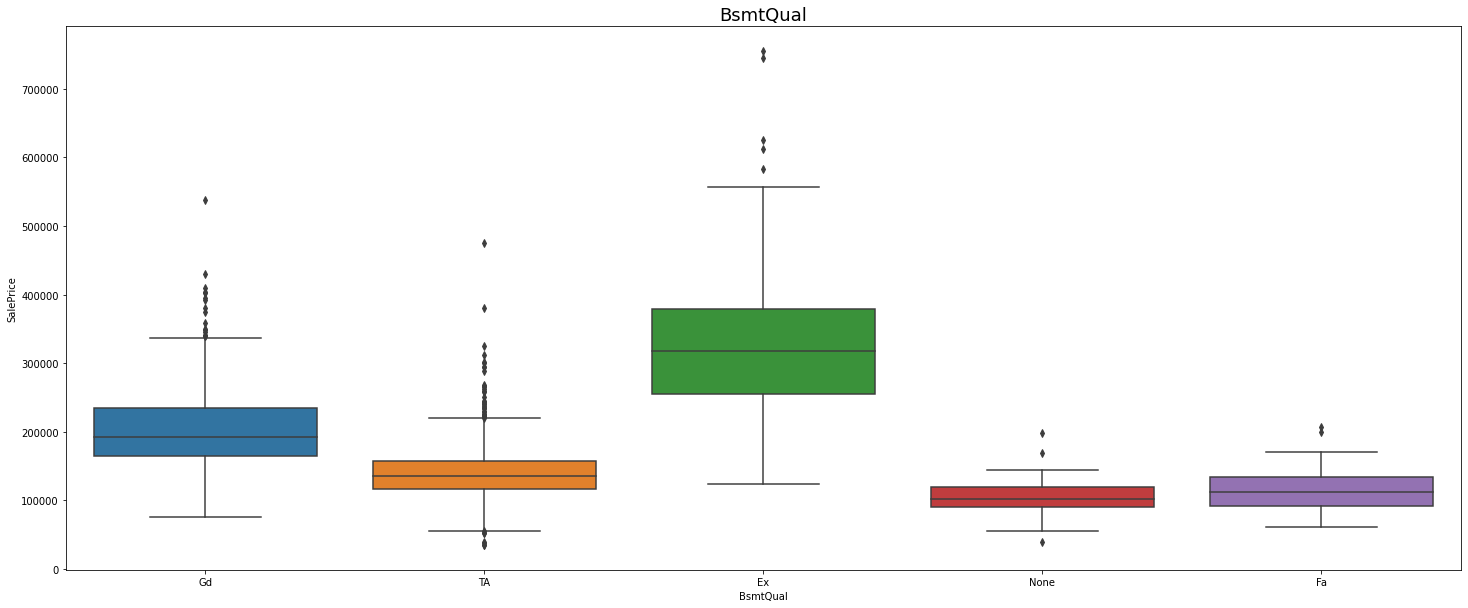

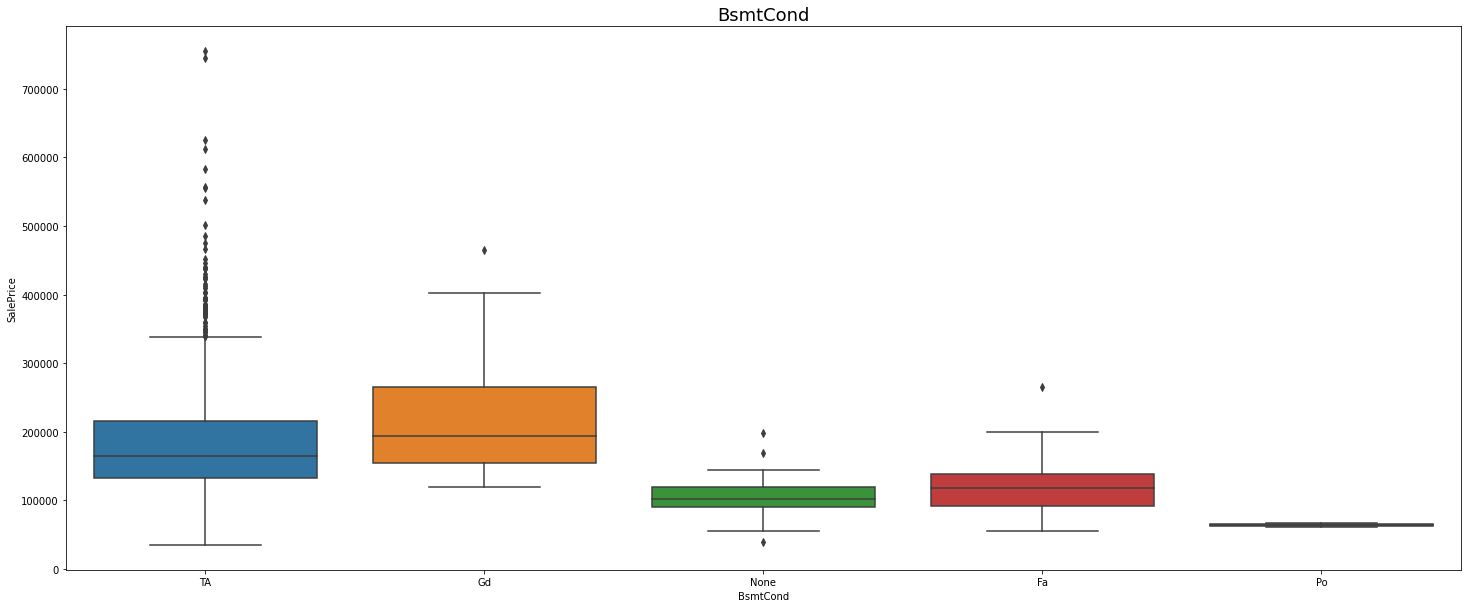

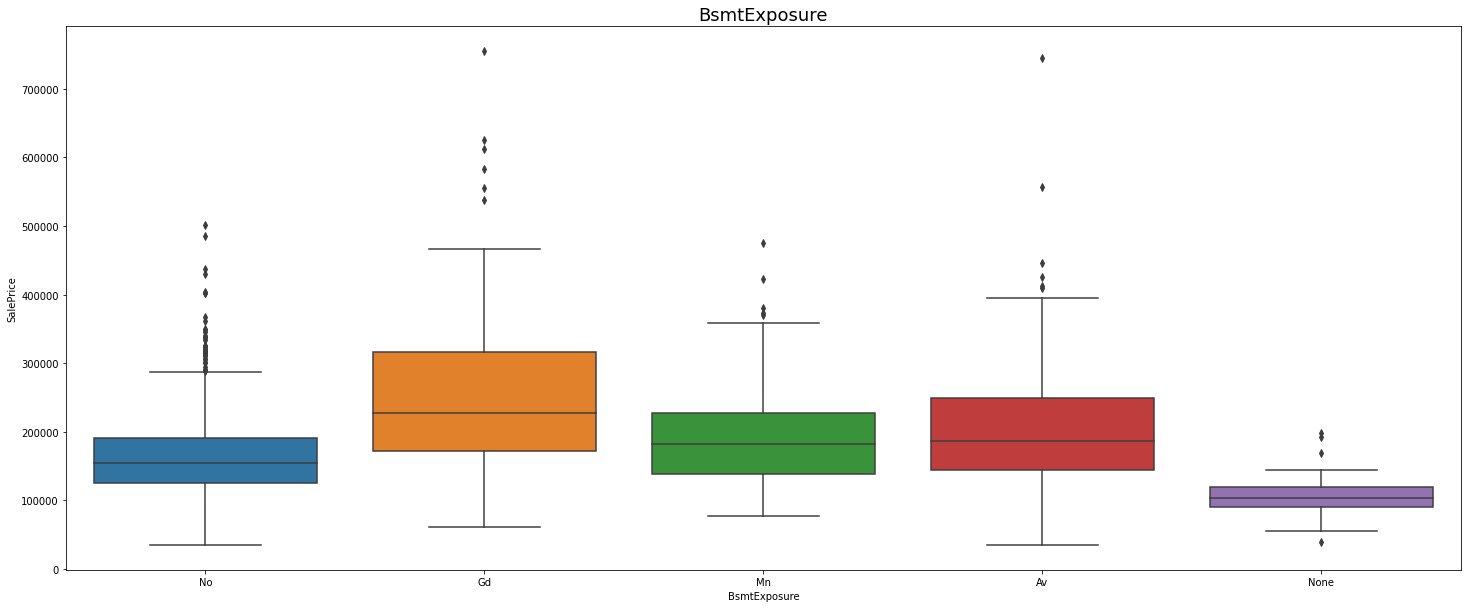

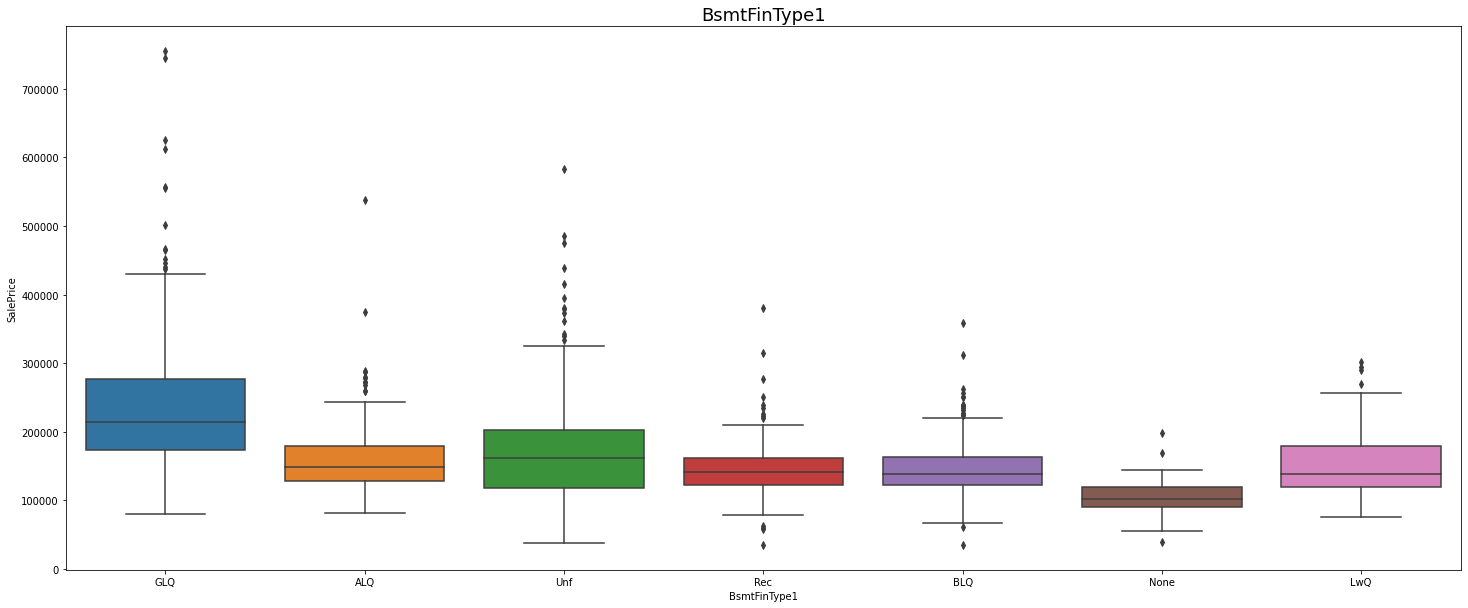

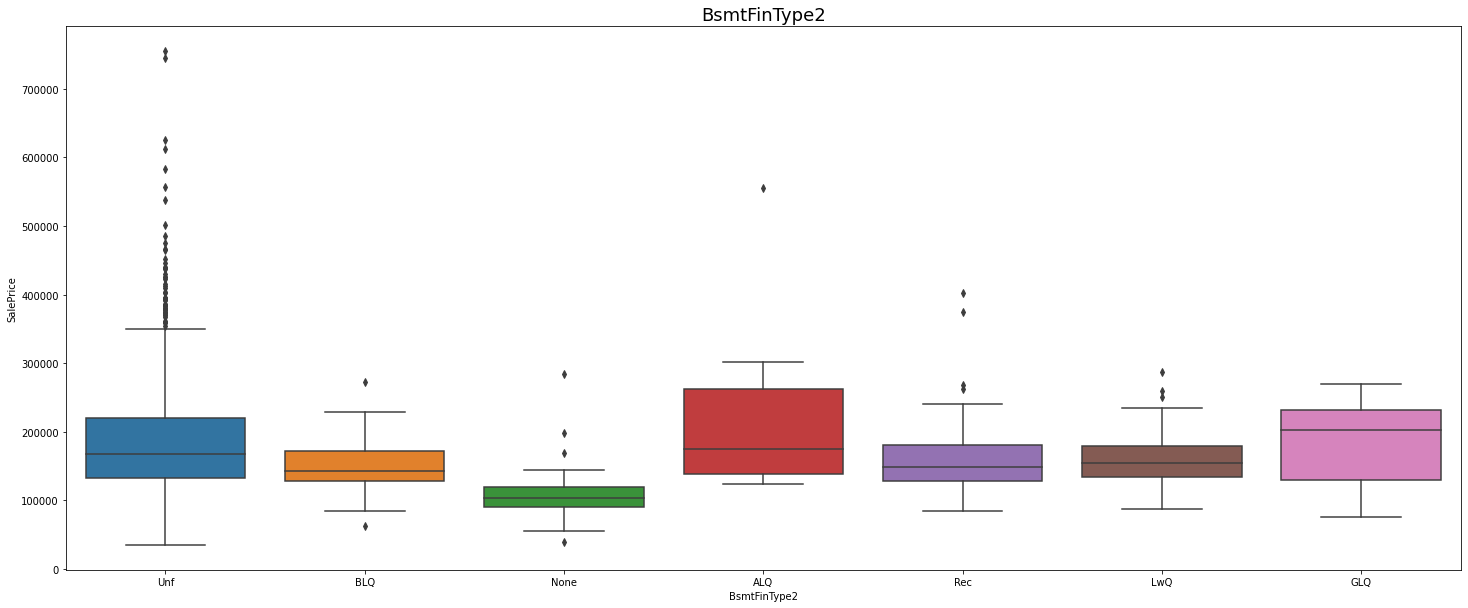

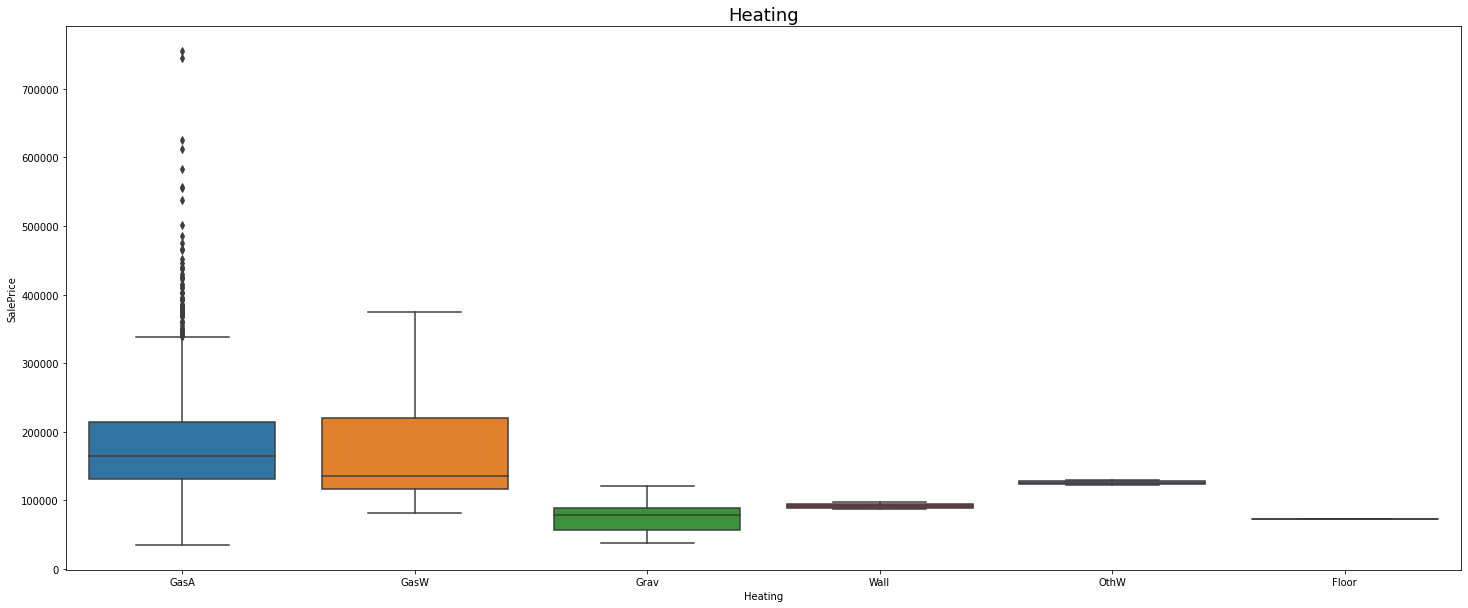

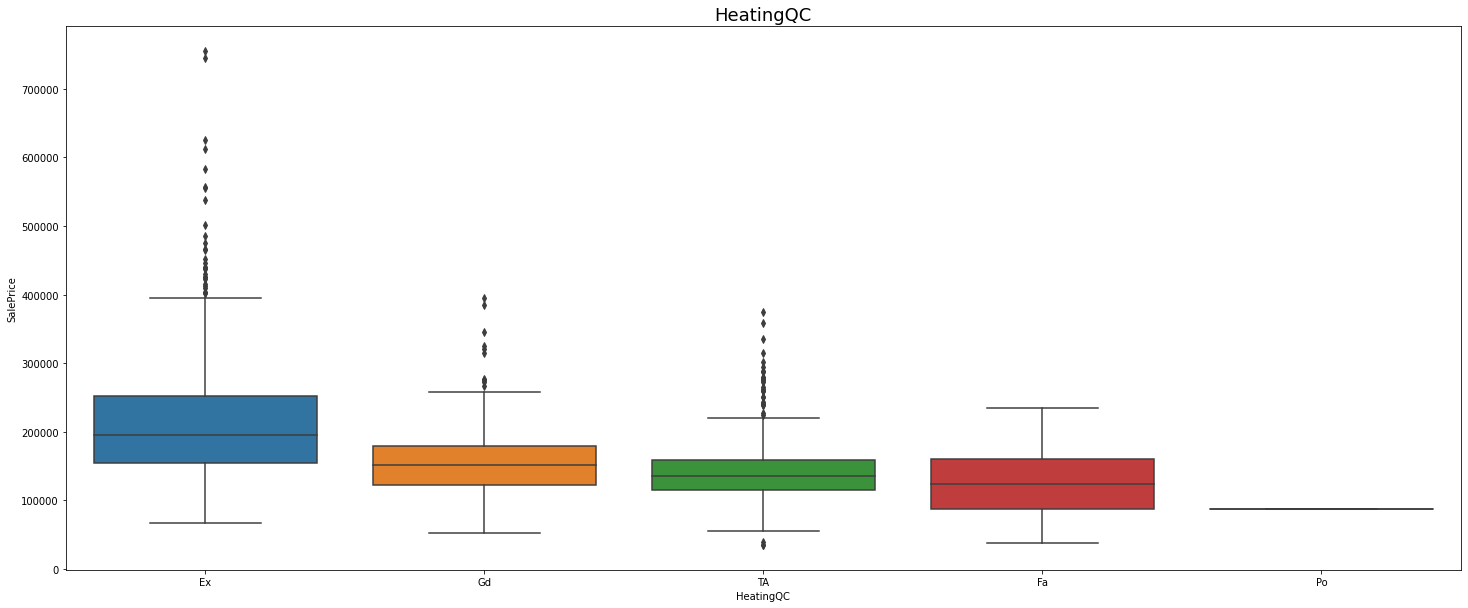

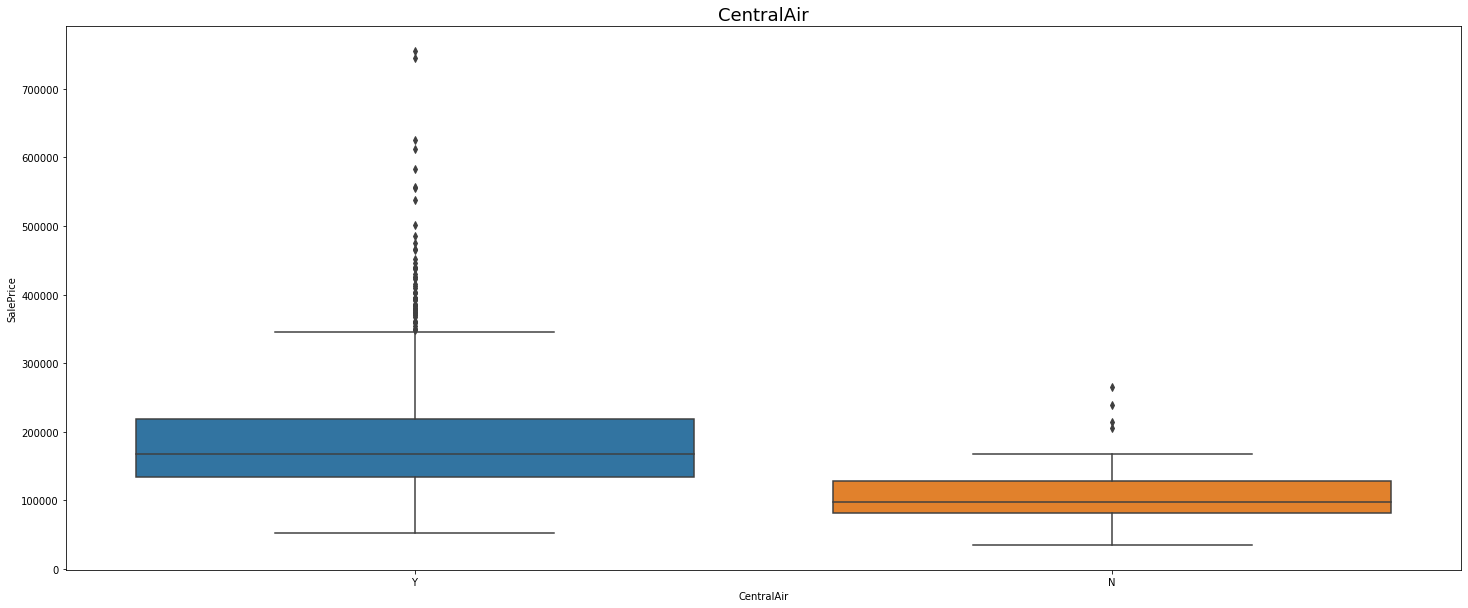

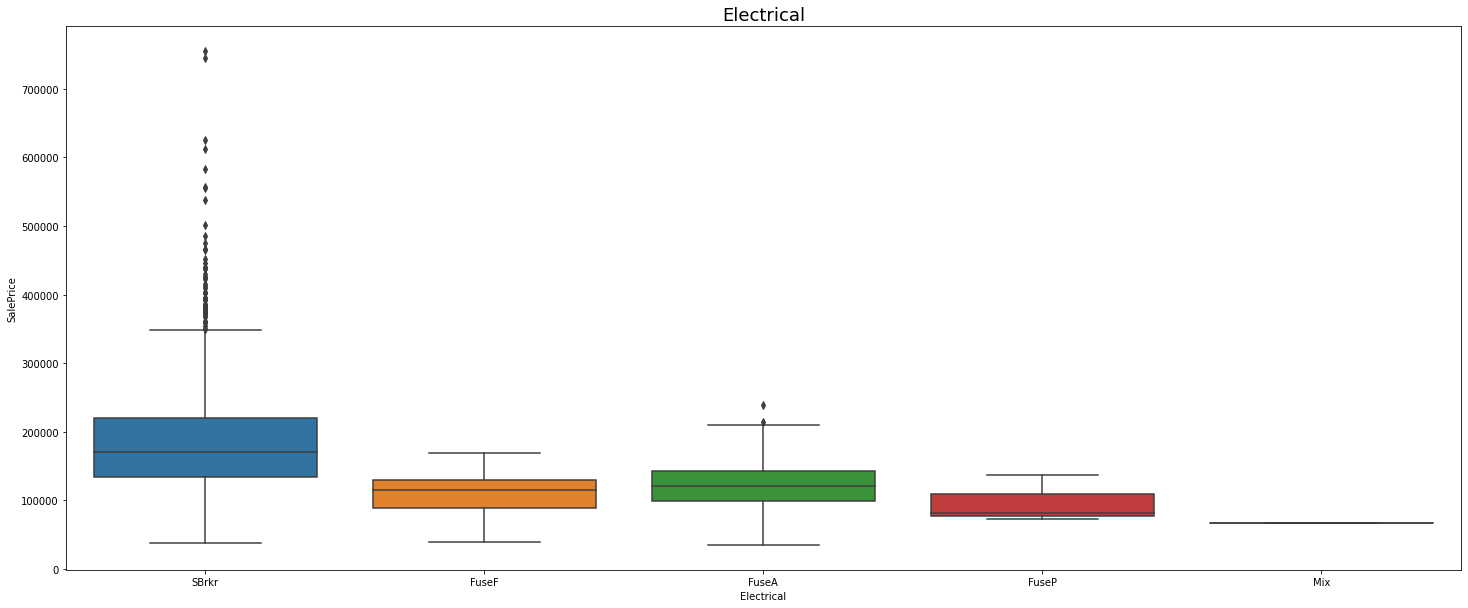

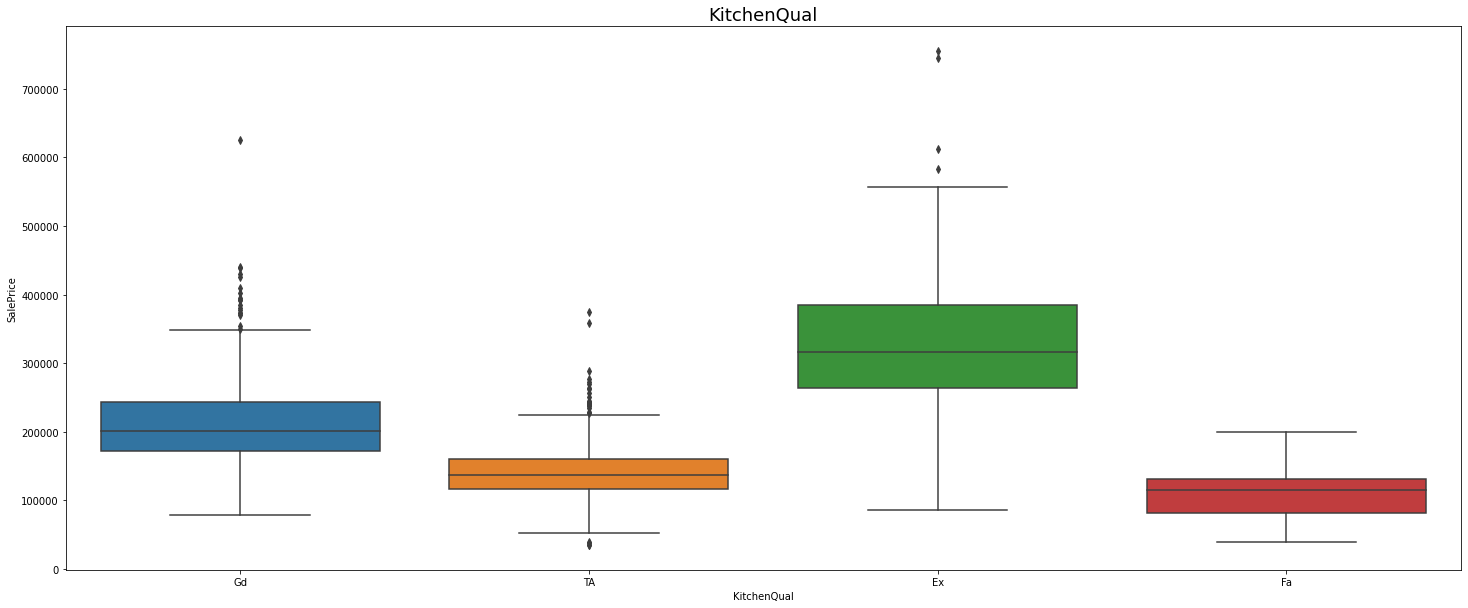

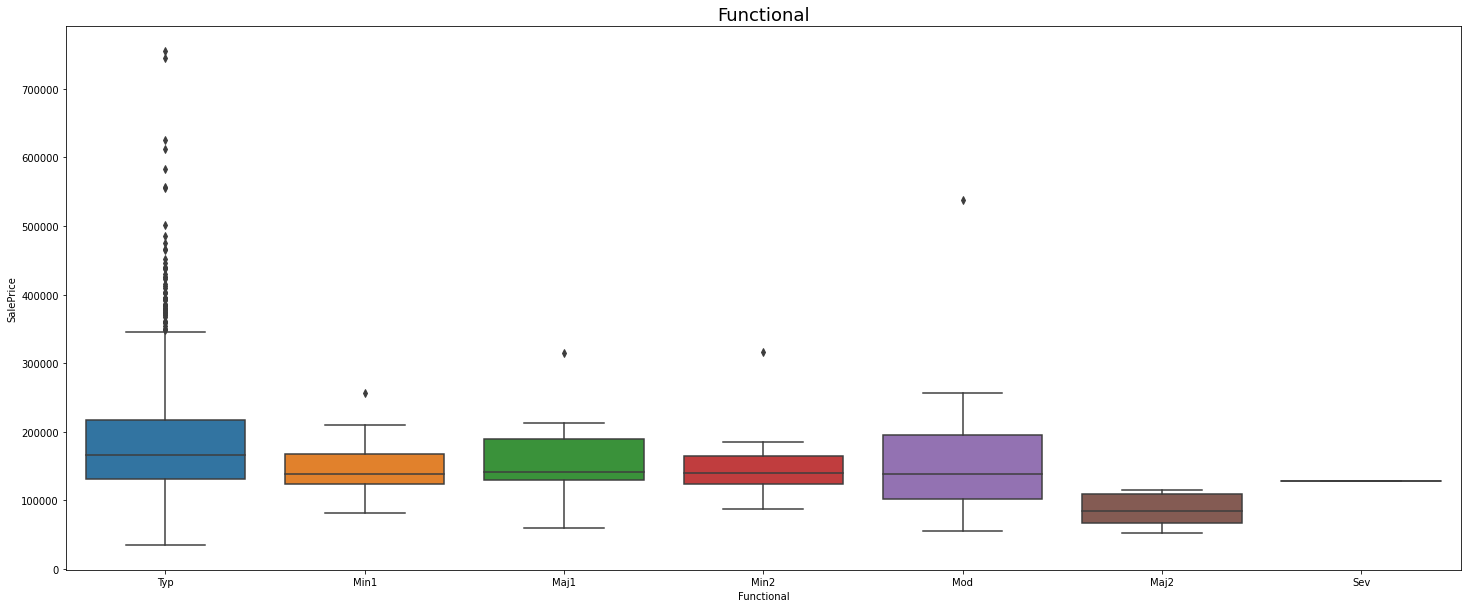

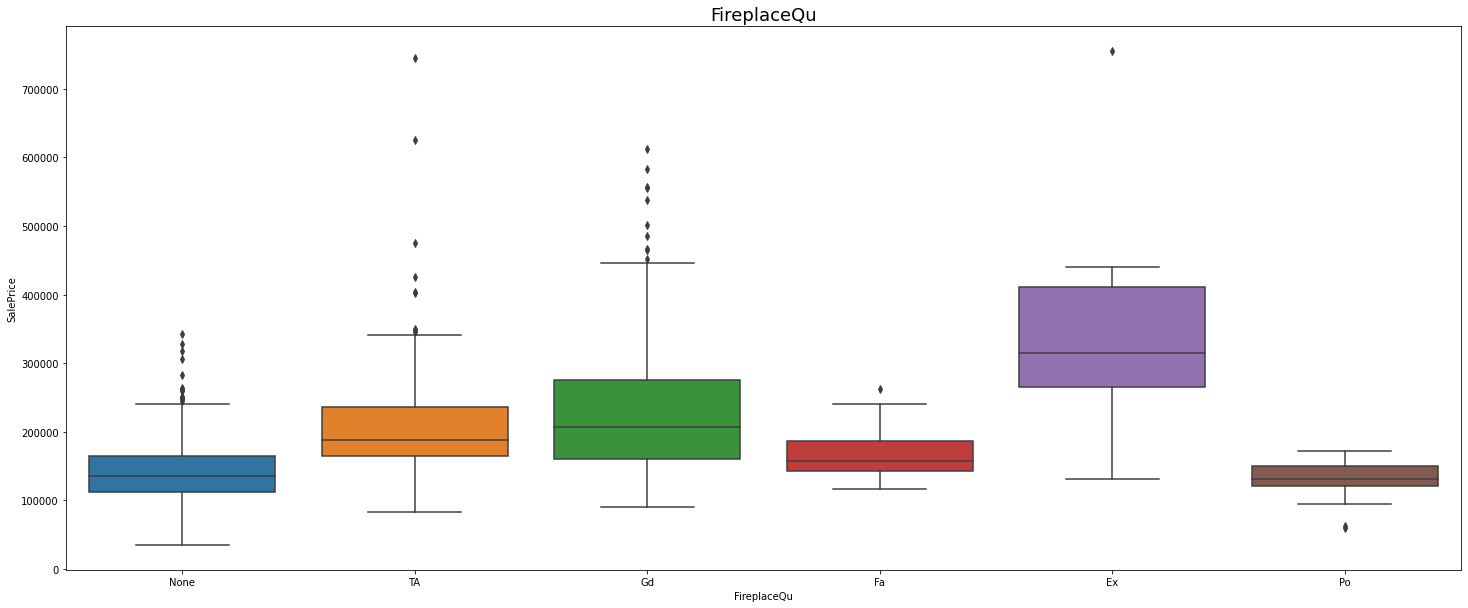

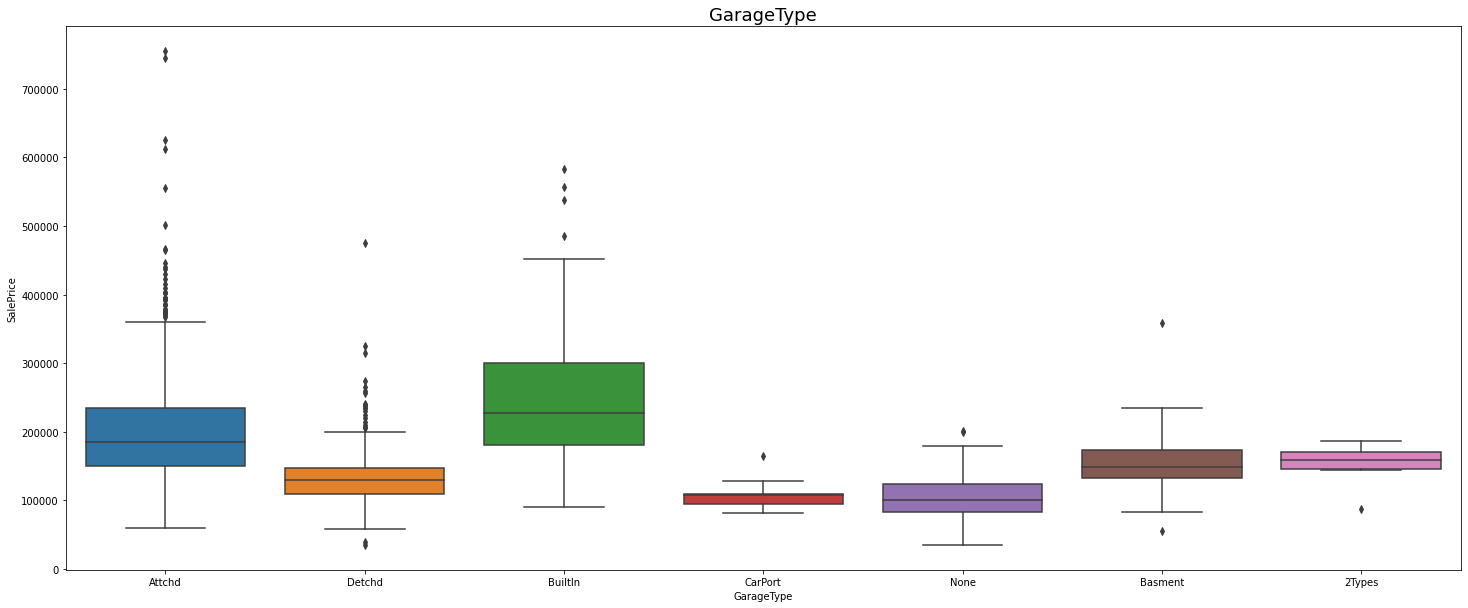

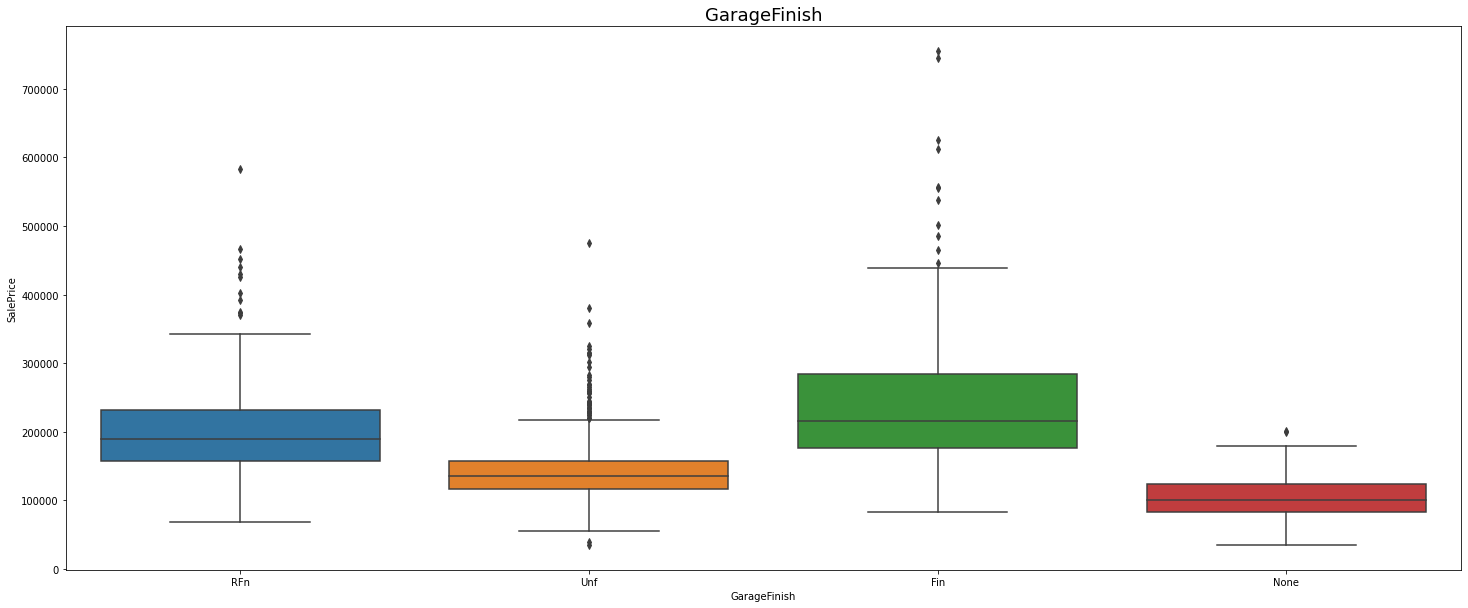

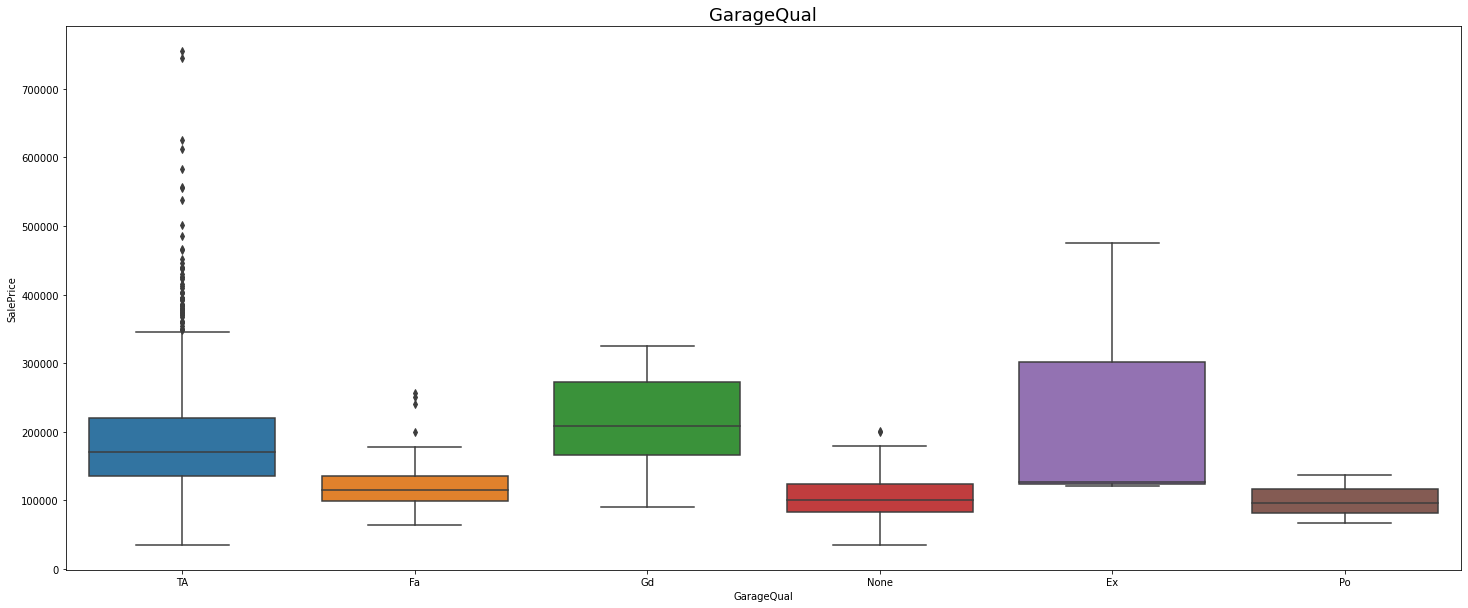

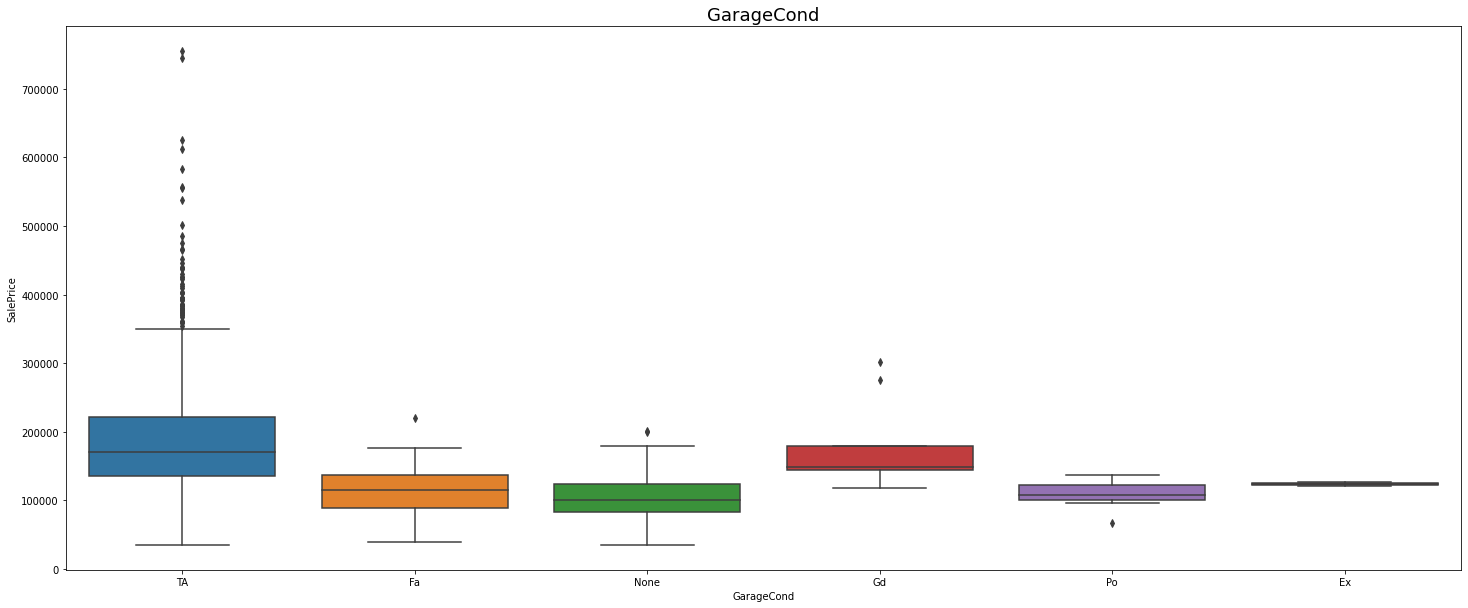

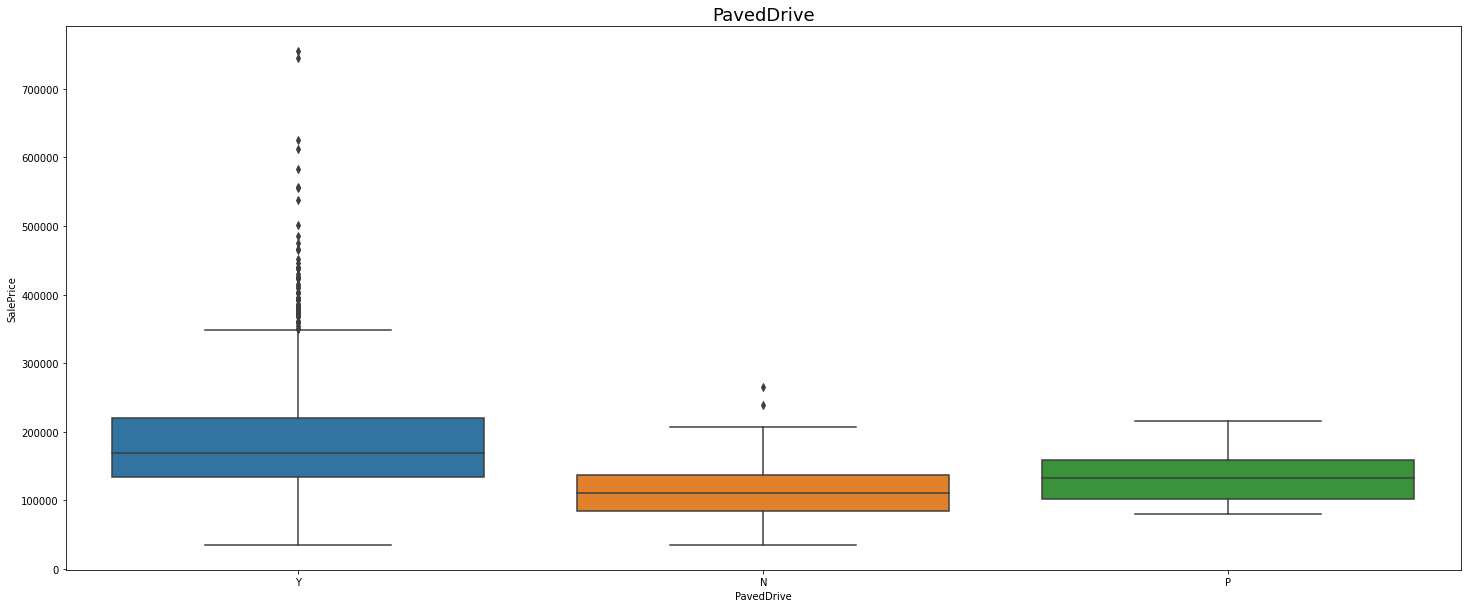

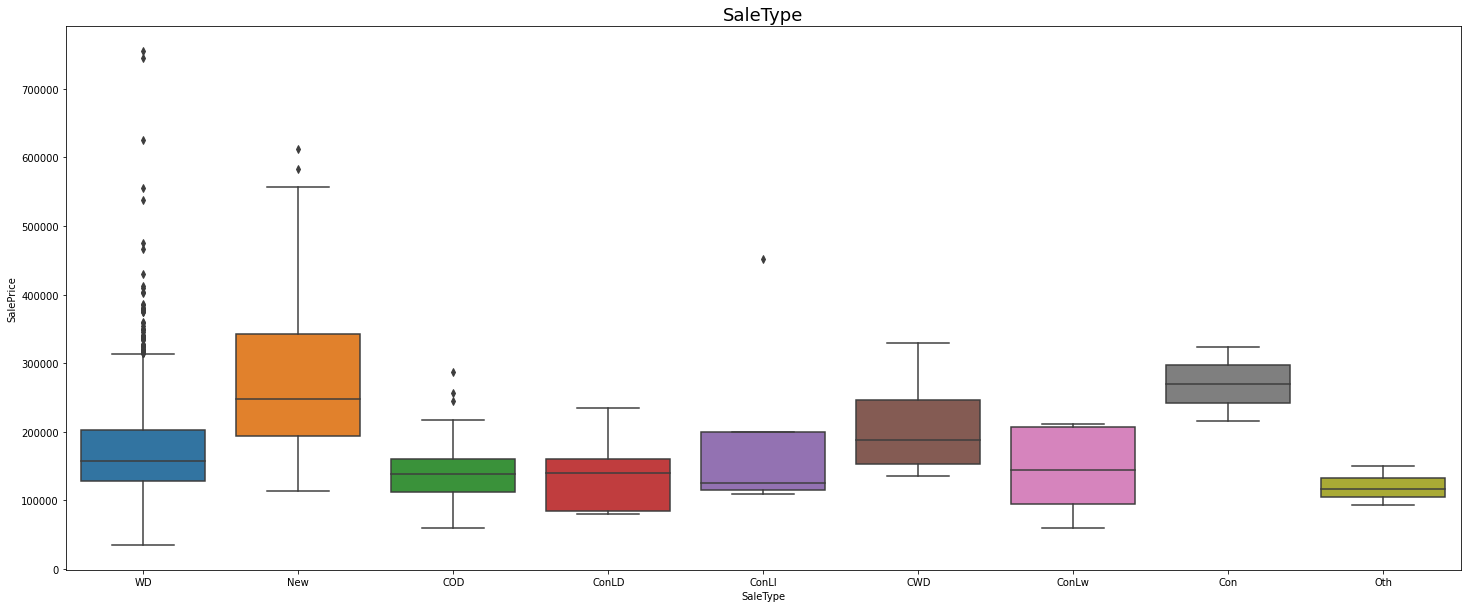

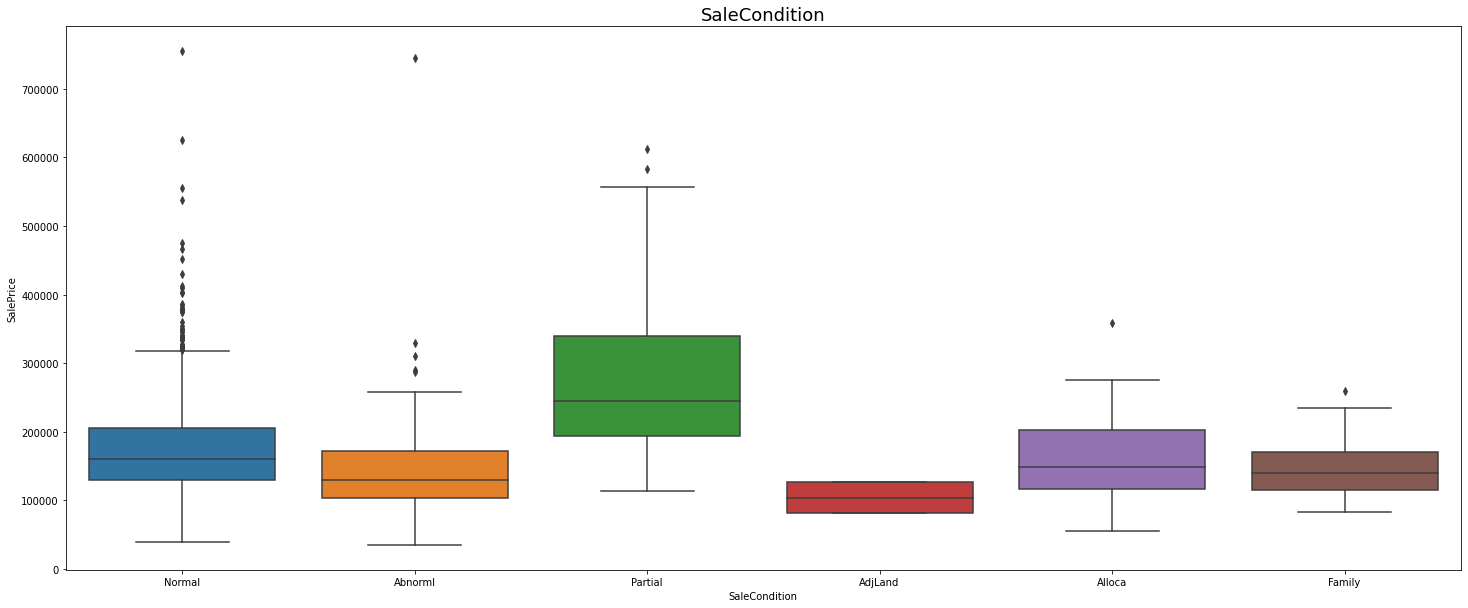

In [385]:
# Build boxplot of all categorical variables (before creating dummies) againt the target variable 'SalePrice' 


def draw_box_plots(columns):
  for col in columns:
      plt.figure(figsize=(25, 10))
      plt.title(col, fontdict={'fontsize': 18})
      sns.boxplot(x = col, y = 'SalePrice', data = housing)
      plt.show()

draw_box_plots(cat_columns)

Inference
 - The categorical variables such as SaleCondition,SaleType, GarageQuality, GarageCondition,Electrical,CentralAir heavily influence the sale price. These could be predictors.

Plot Correlation matrix

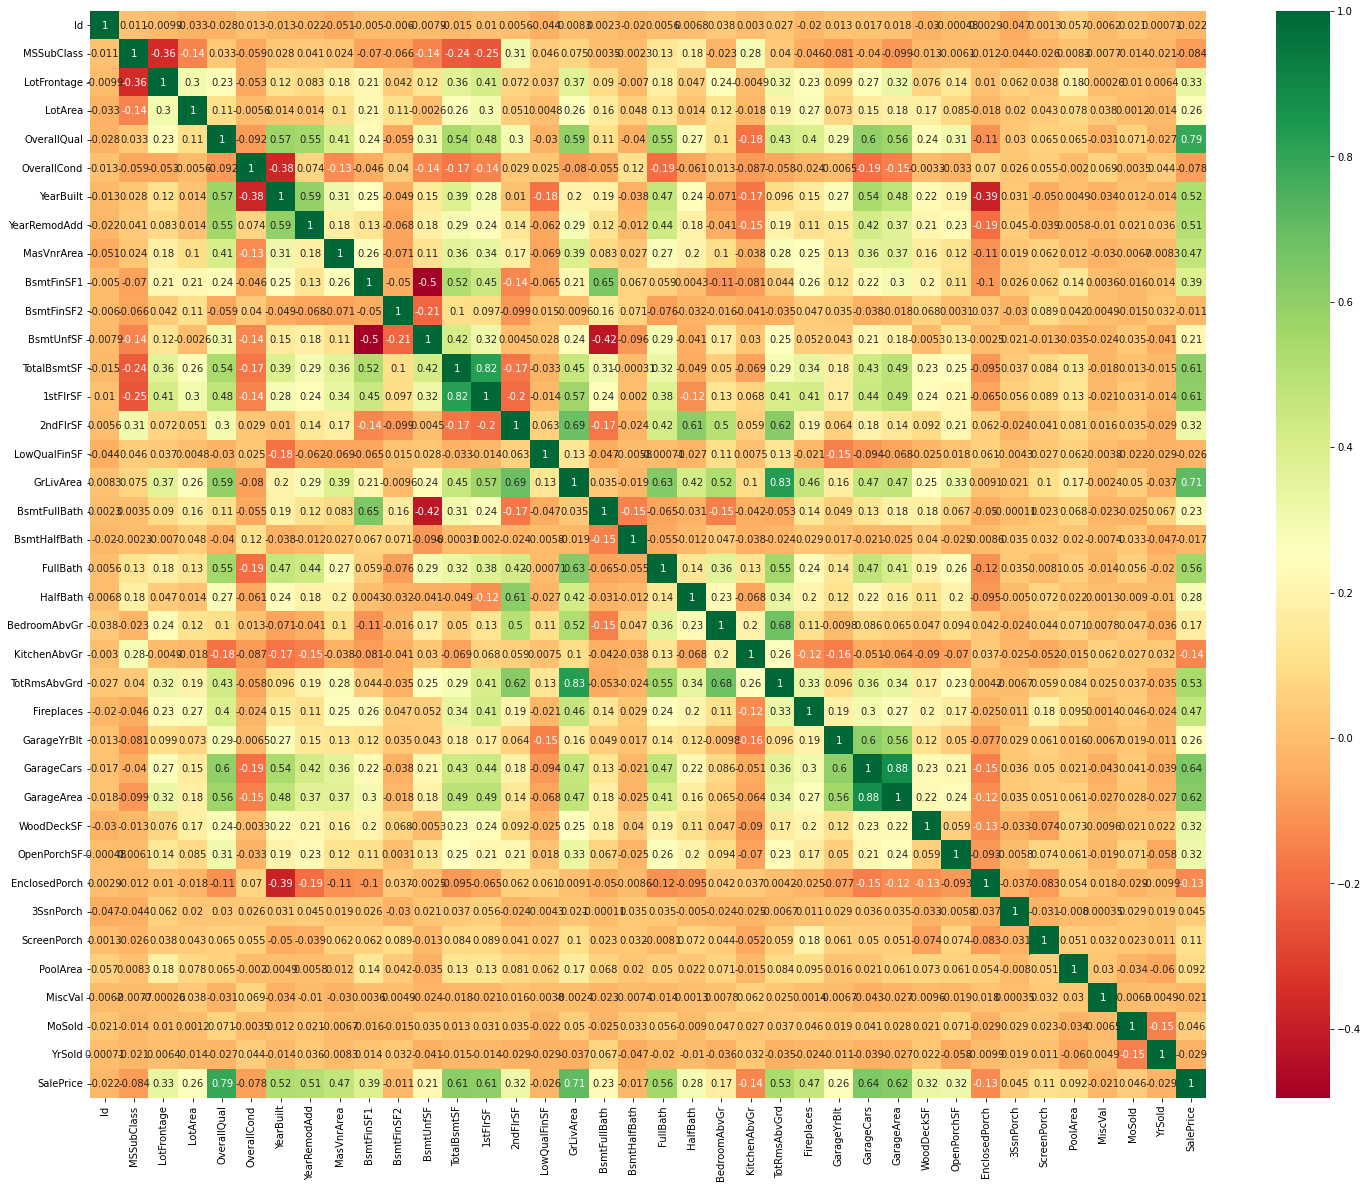

In [386]:
plt.figure(figsize = (25,20))
sns.heatmap(housing.corr(), annot = True, cmap='RdYlGn')
plt.show()

Inference 
- You can see high cor-relation between certain variables.
- SalePrice is most cor-related with OverallQual, YearBuilt, YearRemodAdd, MasVnrArea, TotalBsmtSF, 1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd, FirePlaces, GarageCars, GarageArea.
- We will use VIF and p-value to select/eliminate certain predictors during model building.

# Step 3: Data preparation and processing. 


Outlier Treatment

(1460, 77)
(1063, 77)


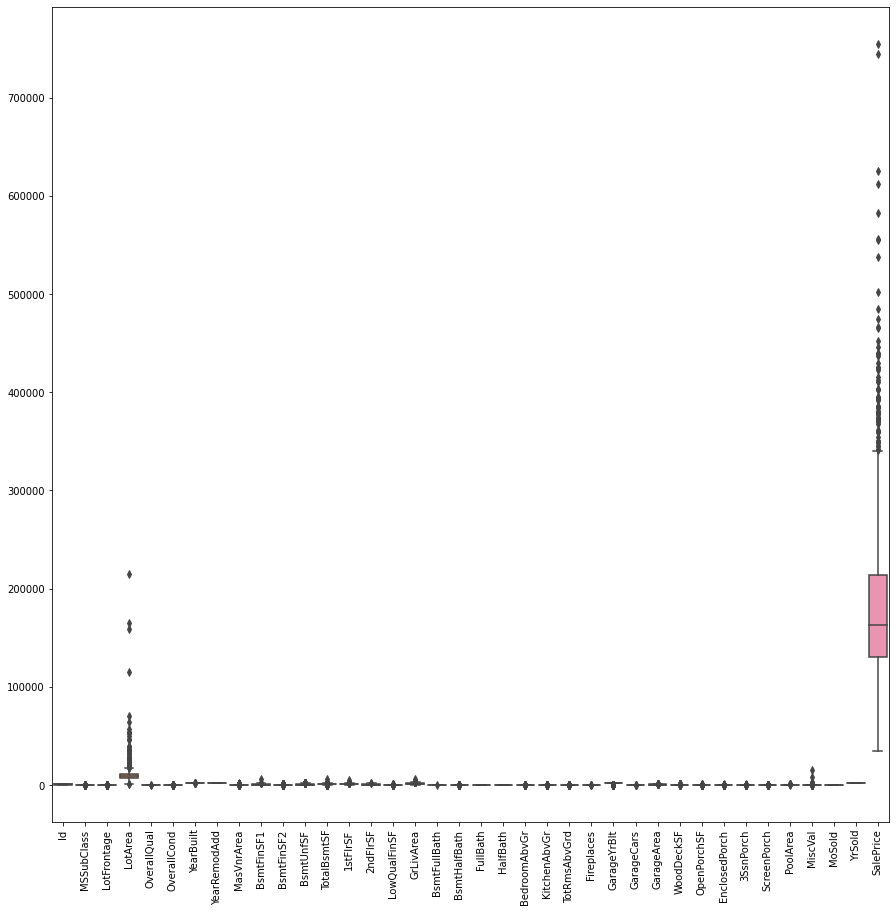

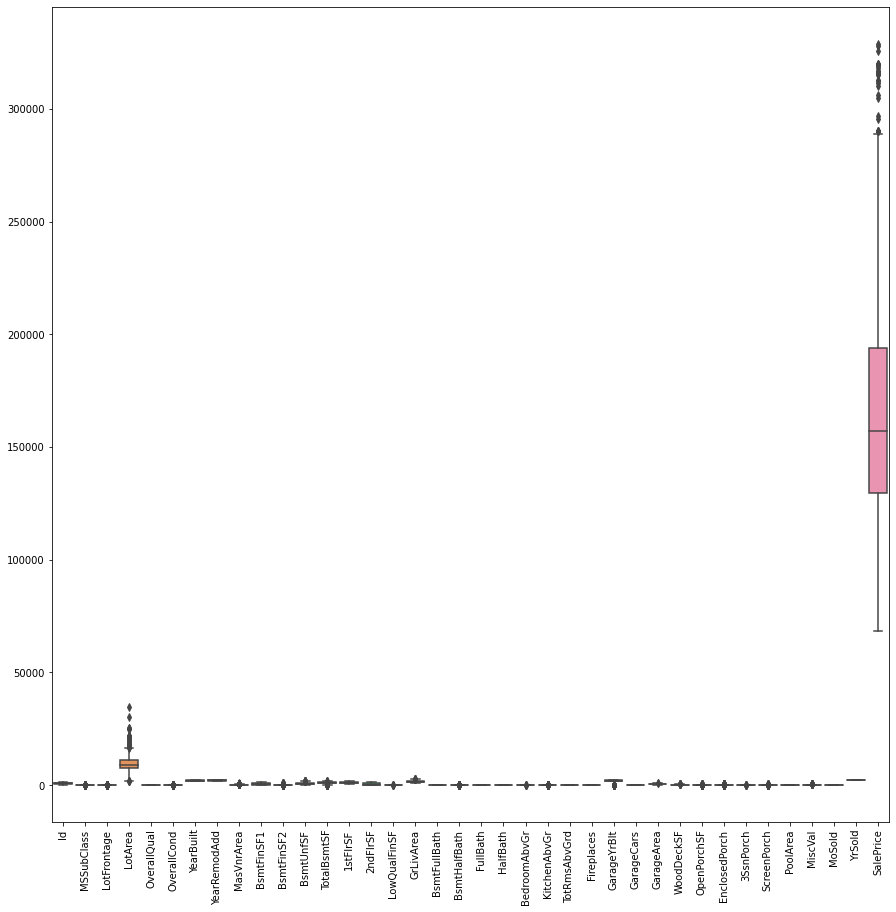

In [387]:
print(housing.shape)
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=housing);

# keeping values which are only greater than quantile(0.01) and less than quantile(0.99).
for col in numerical_columns:
  housing = housing[(housing[col] >= housing[col].quantile(0.01))&(housing[col] <= housing[col].quantile(0.99))]

# check boxplots again to see if outliers are treated
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=housing);
print(housing.shape)

# some outliers have been removed. Much lower quantile values reduce the number of rows.

Create dummy variables for categorical data


In [388]:
## One hot encoding the categorical columns
print(housing.head(5))
for col in cat_columns:
  # Let's drop the first column from status df using 'drop_first = True'
  encoded = pd.get_dummies(housing[col], drop_first = True)
  # Add the results to the original housing dataframe
  housing = pd.concat([housing, encoded], axis = 1)
  # Drop col as we have created the dummies for it
  housing.drop([col], axis = 1, inplace = True)
print(housing.head(5))

    Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
15  16          45       RM         51.0     6120   Pave      Reg         Lvl   
17  18          90       RL         72.0    10791   Pave      Reg         Lvl   
18  19          20       RL         66.0    13695   Pave      Reg         Lvl   
19  20          20       RL         70.0     7560   Pave      Reg         Lvl   
21  22          45       RM         57.0     7449   Pave      Reg         Bnk   

   Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch PoolArea  \
15    AllPub    Corner  ...             0         0           0        0   
17    AllPub    Inside  ...             0         0           0        0   
18    AllPub    Inside  ...             0         0           0        0   
19    AllPub    Inside  ...             0         0           0        0   
21    AllPub    Inside  ...           205         0           0        0   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  Sale

#Step 4: Model Building

In [389]:
X = housing.drop(["Id", "SalePrice"], axis=1).copy()
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
15,45,51.0,6120,7,8,1929,2001,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
17,90,72.0,10791,4,5,1967,1967,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
18,20,66.0,13695,5,5,2004,2004,0.0,646,0,...,0,0,0,0,1,0,0,0,1,0
19,20,70.0,7560,5,6,1958,1965,0.0,504,0,...,0,0,0,0,0,0,0,0,0,0
21,45,57.0,7449,7,7,1930,1950,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [390]:
y = housing["SalePrice"].copy()
y.head()


15    132000
17     90000
18    159000
19    139000
21    139400
Name: SalePrice, dtype: int64

In [391]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape)
print(y_train.shape)

(850, 232)
(850,)


##Scaling

In [392]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

In [393]:
## Create a scaling instance

scaler = StandardScaler()
## Scale the numerical columns 
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
count,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,...,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,-7.523394e-17,1.964442e-16,2.340611e-16,-2.162976e-16,2.925764e-16,2.006238e-16,4.110699e-15,1.880848e-17,2.089832e-17,-6.478478e-17,...,0.002353,0.002353,0.061176,0.001176,0.888235,0.002353,0.003529,0.011765,0.857647,0.063529
std,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00,...,0.048479,0.048479,0.239795,0.034300,0.315262,0.048479,0.059339,0.107889,0.349617,0.244056
min,-8.704755e-01,-2.764831e+00,-2.158477e+00,-2.508932e+00,-2.491021e+00,-2.486272e+00,-1.655549e+00,-5.694973e-01,-1.035343e+00,-3.076295e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.704755e-01,-4.730762e-01,-5.607577e-01,-7.994392e-01,-5.748509e-01,-6.086827e-01,-8.785909e-01,-5.694973e-01,-1.035343e+00,-3.076295e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.370499e-01,5.579023e-02,-6.712238e-02,5.530712e-02,-5.748509e-01,1.718056e-02,3.839657e-01,-5.694973e-01,-1.173681e-01,-3.076295e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.519005e-01,4.083679e-01,4.672142e-01,9.100535e-01,3.832339e-01,9.907456e-01,9.181243e-01,2.856569e-01,7.321205e-01,-3.076295e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,3.285603e+00,4.051670e+00,7.144270e+00,2.619546e+00,3.257488e+00,1.303677e+00,1.209484e+00,4.656445e+00,2.799868e+00,5.799814e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## MODEL 1 : Ridge Regression

In [ ]:
def calculate_metrics(train,pred):
  r2 = r2_score(train, pred)
  print(r2)
  rss = np.sum(np.square(train - pred))
  print(rss)
  mse = mean_squared_error(train, pred)
  print(mse)
  # Root Mean Squared Error
  rmse = mse**0.5
  print(rmse)

In [396]:
## we will run a cross validation on a list of alphas to find the optimum value of alpha

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                    2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

ridge = Ridge()
# cross validation
ridgeCV = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1, n_jobs=-1)            
ridgeCV.fit(X_train, y_train) 

print(ridgeCV.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 4.0}


### Optimum value of alpha is 4.0.
 We will build a Ridge Model using the alpha
 

In [2]:
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

NameError: ignored